# UK  road accidents and safety data

### Description

Data contains information about the circumstances of personal injury road accidents in Great Britain in 2014. The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form. Information on damage-only accidents, with no human casualties or accidents on private roads or car parks are not included in this data.

### Importing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# from pandas_ml import ConfusionMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.utils.multiclass import unique_labels
import time
import matplotlib

from datetime import date
import holidays

In [2]:
plt.style.use("dark_background")
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("husl"))
######################################################################
pd.set_option("display.max_columns", 15,"display.width",1000)
pd.set_option("display.max_rows", 50)


## Some useful functions

In [3]:

def conv_tf(l):
    l_b=[]
    for i in l:
        if i[0] == True:
            l_b.append('YES')
        else:
            l_b.append('NO')
    return np.array(l_b)



def conv_b(l):
    l_b=[]
    for i in l:
        if i=='YES':
            l_b.append(1)
        else:
            l_b.append(0)
    return np.array(l_b)

def conv_s(l):
    l_s=[]
    for i in l:
        if i==1:
            l_s.append('YES')
        else:
            l_s.append('NO')
    return np.array(l_s)


def conf_m(t,real_l,pred_l):
    pred_thr=[]
    for i in pred_l:
        if i>=t:
            # print i
            pred_thr.append(1)
        else:
            pred_thr.append(0)
    return confusion_matrix(real_l, pred_thr)


def readable_time(seconds):
    """Returns h:mm:ss formatted time from time in seconds.

    Args:
        seconds (float): Number of seconds to convert to readable time.

    """
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return "%d:%02d:%02d" % (h, m, s)


def confusion_matrix_max(frame, pred_col, real_col, threshold):
    """Creates a confusion matrix based on the truth value of the predictions and a threshold.

    Args:
        frame (H2OFrame, DataFrame): Frame with headers.
        pred_col (str): Name of column with predictions.
        real_col (str): Name of column with actuals.
        threshold (float): Threshold determining vote of prediction column.

    Returns:
        ConfusionMatrix
    """
    predicted = frame[pred_col].apply(lambda row: 1 if row >= threshold else 0)
    real = frame[real_col]
    matrix = ConfusionMatrix(list(real), list(predicted))

    return matrix, matrix.precision, threshold


def draw_roc(frame,model,if_print=True):
    """Plots and ROC curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    fpr, tpr, thr = roc_curve(real, p_yes_dnn)
    roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn


def draw_prec_recall(frame,model,if_print=True):
    """Plots and Precision Recall curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    precision, recall, thr = precision_recall_curve(real, p_yes_dnn)
    # roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.step(recall, precision, color='b', alpha = 0.2, where= 'post')
    plt.fill_between(recall,precision, alpha=0.2, color='b')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Sensitivity, TPR)')
    plt.ylabel('Precision')
    plt.title('Precision - Recall curve {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn


def draw_prec_thr(frame,model,if_print=True):
    """Plots and Precision Recall curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    precision, recall, thr = precision_recall_curve(real, p_yes_dnn)
    # roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.step(thr, precision[:-1], color='r', alpha = 0.2, where= 'post')
    plt.fill_between(thr,precision[:-1], alpha=0.2, color='r')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision - Threshold curve {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn

def plot_confusion_matrix(t,real_l,pred_l, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    pred_thr=[]
    for i in pred_l:
        if i>=t:
            # print i
            pred_thr.append(1)
        else:
            pred_thr.append(0)

    cm = confusion_matrix(real_l, pred_thr)
    ##################################
    # cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(real_l, pred_l)]
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def print_stats(thr,real_v, p_yes_gbm):
    cm = conf_m(thr, real_v, p_yes_gbm)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fp) > 0:
        print('Accuracy = ', round((float(tp)+float(tn)) / (float(tp) + float(fp) + float(tn) + float(fn)), 3)*100)
        print('Precsision = ', round(float(tp) / (tp + fp), 3))
        print('Sensitivity = ', round(float(tp) / (tp + fn), 3))
        print('Specificity = ', round(float(tn) / (tn + fp), 3))
        print('NPV = ', round(float(tn) / (tn + fn), 3))        
        print('F1 = ', round(2*float(tp) / (2*float(tp) + float(fp) + float(fn)),2))
        print('MCC = ',round(np.divide(
                                    (float(tp) * float(tn) - float(fp) * float(fn)),
                                    np.sqrt((float(tp) + float(fp))*
                                            (float(tp) + float(fn))*
                                            (float(tn) + float(fp))*
                                            (float(tn) + float(fn)))),4))
        print('Threshold = ', round(t/1000., 3))
        print( cm)
        

In [4]:
df_acc= pd.read_csv('data/DfTRoadSafety_Accidents_2014.csv')
df_acc

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,...,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,...,2,2,0,0,1,2,E01002814
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,...,1,1,0,0,1,2,E01002894
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,...,1,1,0,0,1,1,E01002822
3,201401BS70004,525580,179080,-0.192311,51.496668,1,3,...,1,1,0,0,1,2,E01002812
4,201401BS70006,527040,179030,-0.171308,51.495892,1,3,...,1,1,0,0,1,1,E01002821
5,201401BS70008,524750,178970,-0.204301,51.495863,1,3,...,1,1,0,0,1,1,E01002814
6,201401BS70009,524950,179240,-0.201326,51.498245,1,3,...,1,2,0,0,1,1,E01002817
7,201401BS70010,523850,181450,-0.216389,51.518349,1,3,...,2,2,0,0,1,1,E01002909
8,201401BS70011,524500,180260,-0.207445,51.507511,1,3,...,1,1,0,0,1,1,E01002871
9,201401BS70013,526450,179230,-0.179731,51.497822,1,3,...,2,2,0,0,1,1,E01002892


In [5]:
# check the Accident_Index is unique
len(df_acc.Accident_Index.unique())

146322

## Exploring the data

The -1's in the data correspond to NULL values, let's substitute and check for nulls

In [6]:
#first check if there are -1's in a string format 
df_acc.eq('-1').sum()

/Users/norayr/opt/anaconda3/envs/dev/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail                                0
Junction_Control                               0
2nd_Road_Class      

In [7]:
#next check how many -1's are in the data and in which columns prediominantly
df_acc.eq(-1).sum()

Accident_Index                                     0
Location_Easting_OSGR                              0
Location_Northing_OSGR                             0
Longitude                                          0
Latitude                                           0
Police_Force                                       0
Accident_Severity                                  0
Number_of_Vehicles                                 0
Number_of_Casualties                               0
Date                                               0
Day_of_Week                                        0
Time                                               0
Local_Authority_(District)                         0
Local_Authority_(Highway)                          0
1st_Road_Class                                     0
1st_Road_Number                                    0
Road_Type                                          0
Speed_limit                                        0
Junction_Detail                               

In [8]:
# replace and check the replacemnet was correct
df_acc.replace(-1,np.nan, inplace=True)
df_acc.isna().sum()

Accident_Index                                     0
Location_Easting_OSGR                              0
Location_Northing_OSGR                             0
Longitude                                          0
Latitude                                           0
Police_Force                                       0
Accident_Severity                                  0
Number_of_Vehicles                                 0
Number_of_Casualties                               0
Date                                               0
Day_of_Week                                        0
Time                                               0
Local_Authority_(District)                         0
Local_Authority_(Highway)                          0
1st_Road_Class                                     0
1st_Road_Number                                    0
Road_Type                                          0
Speed_limit                                        0
Junction_Detail                               

The response variable does not have missing data, and there does not seemt to be bad data quality issues except in few columns. Let's chek the data balance:

In [9]:
#Check the third option is abscent 
#from the response variable (as noted in the variable description)
df_acc.Did_Police_Officer_Attend_Scene_of_Accident.unique()

array([2, 1])

In [10]:
# replace 2 with 0 for police not showing up 
df_acc.Did_Police_Officer_Attend_Scene_of_Accident.replace(2,0, inplace=True)

# df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{1:0}},
#                inplace=True)
# df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{2:1}},
#                inplace=True)

#check the imbalance
print (df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
       format(round((df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                     len(df_acc))*100)))

119607 26715
Police attended in the 18.0% of cases


In [11]:
#Create the date time column
df_acc['dt'] = pd.to_datetime(df_acc.Date+' '+df_acc.Time)

In [12]:
df_acc['Month'] = df_acc.dt.dt.month 
df_acc['Hour'] = df_acc.dt.dt.hour
df_acc

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,...,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,dt,Month,Hour
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,...,0.0,1,0,E01002814,2014-09-01 13:21:00,9,13
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,...,0.0,1,0,E01002894,2014-01-20 23:00:00,1,23
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,...,0.0,1,1,E01002822,2014-01-21 10:40:00,1,10
3,201401BS70004,525580,179080,-0.192311,51.496668,1,3,...,0.0,1,0,E01002812,2014-01-15 17:45:00,1,17
4,201401BS70006,527040,179030,-0.171308,51.495892,1,3,...,0.0,1,1,E01002821,2014-09-01 08:50:00,9,8
5,201401BS70008,524750,178970,-0.204301,51.495863,1,3,...,0.0,1,1,E01002814,2014-01-17 14:11:00,1,14
6,201401BS70009,524950,179240,-0.201326,51.498245,1,3,...,0.0,1,1,E01002817,2014-10-01 18:25:00,10,18
7,201401BS70010,523850,181450,-0.216389,51.518349,1,3,...,0.0,1,1,E01002909,2014-01-30 17:50:00,1,17
8,201401BS70011,524500,180260,-0.207445,51.507511,1,3,...,0.0,1,1,E01002871,2014-10-01 10:55:00,10,10
9,201401BS70013,526450,179230,-0.179731,51.497822,1,3,...,0.0,1,1,E01002892,2014-05-01 20:26:00,5,20


#### Accident Severity

,Count
Fatal,1658
Serious,20676
Slight,123988


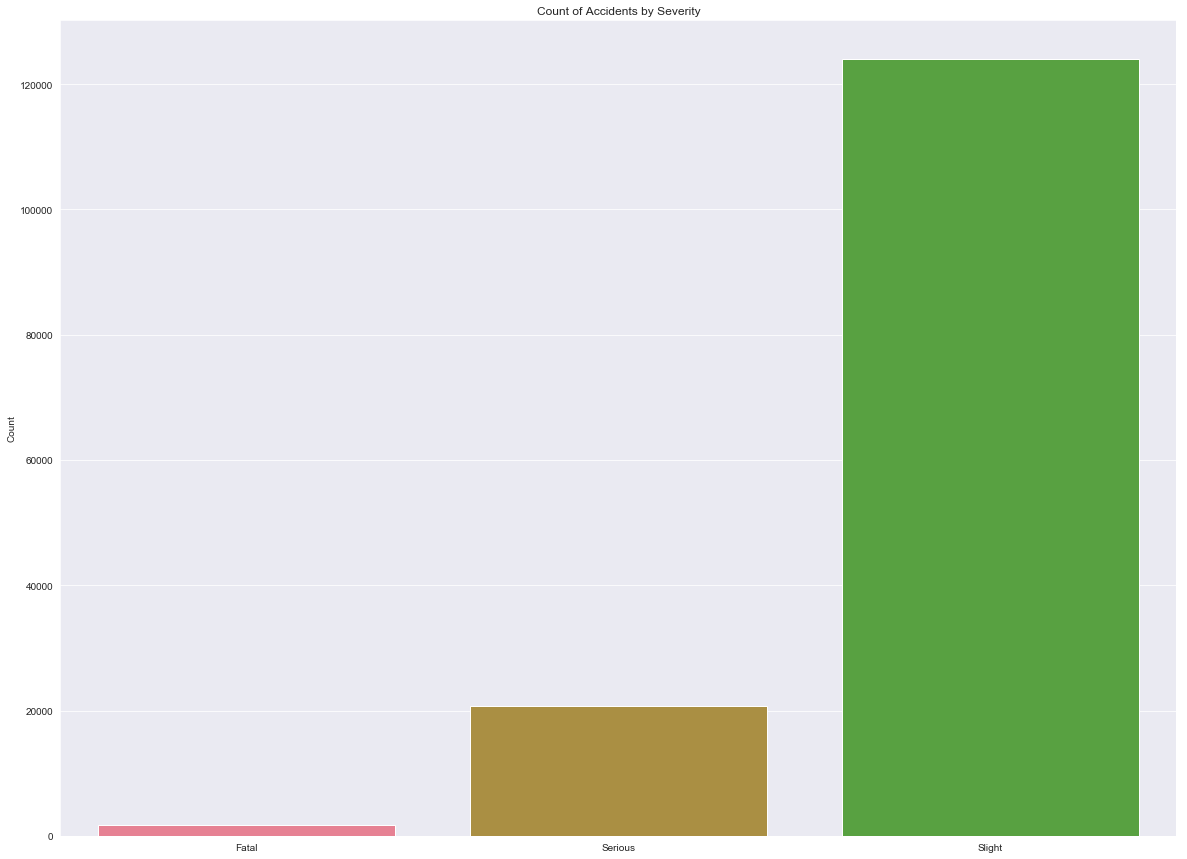

In [13]:
severeity=pd.DataFrame.from_dict(
    {'Fatal':df_acc.Accident_Severity.value_counts()[1],
             'Serious':df_acc.Accident_Severity.value_counts()[2], 
             'Slight':df_acc.Accident_Severity.value_counts()[3]},
    orient='index', columns=['Count'])

plt.figure(2, figsize=(20,15))
sns.barplot(x=severeity.index, y='Count',data=severeity)
plt.title('Count of Accidents by Severity')

severeity


,Accident_Severity,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Fatal,NO,20
1,Fatal,YES,1638
2,Serious,NO,1941
3,Serious,YES,18735
4,Slight,NO,24754
5,Slight,YES,99234


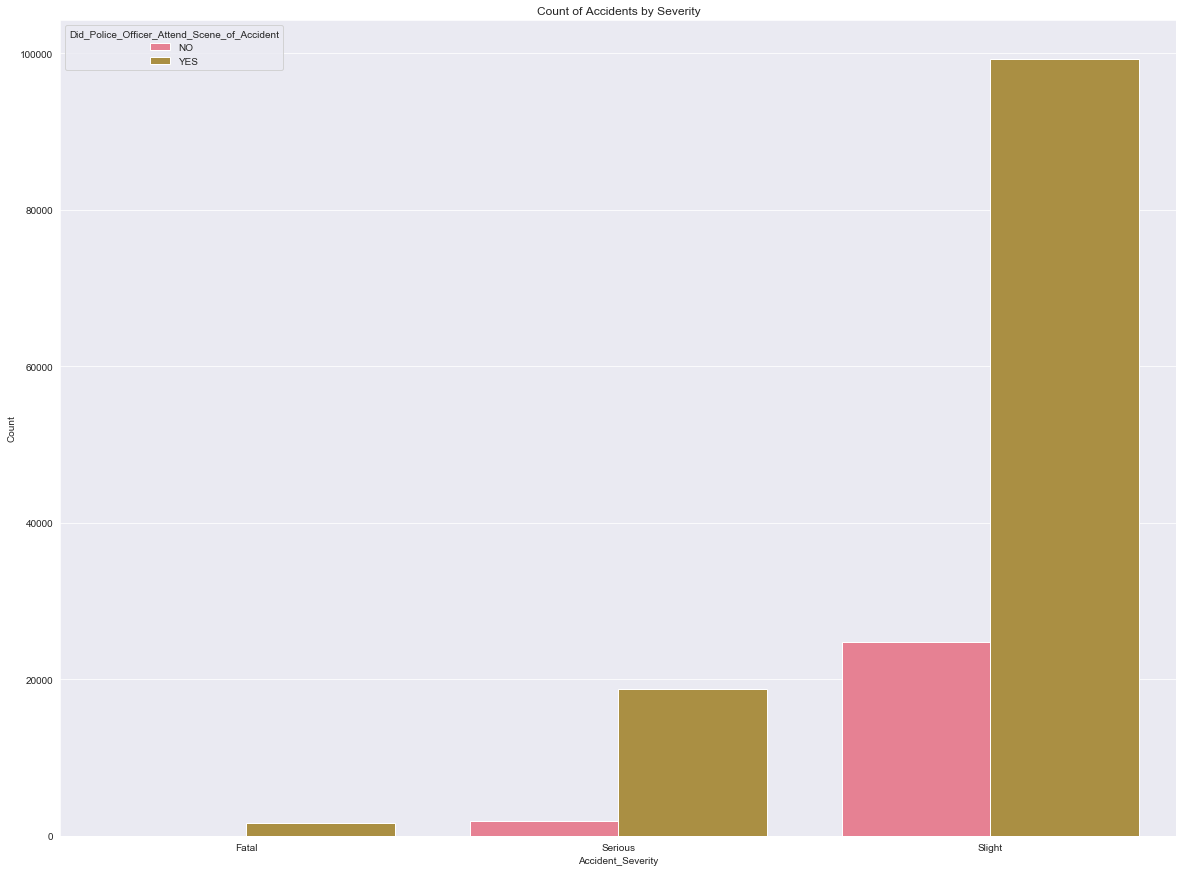

In [14]:
sever_by_attend=df_acc.replace({'Accident_Severity':{1:'Fatal',2:'Serious',3:'Slight'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Accident_Severity','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Accident_Severity','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Accident_Severity', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=sever_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Severity')

sever_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Accident Severity')

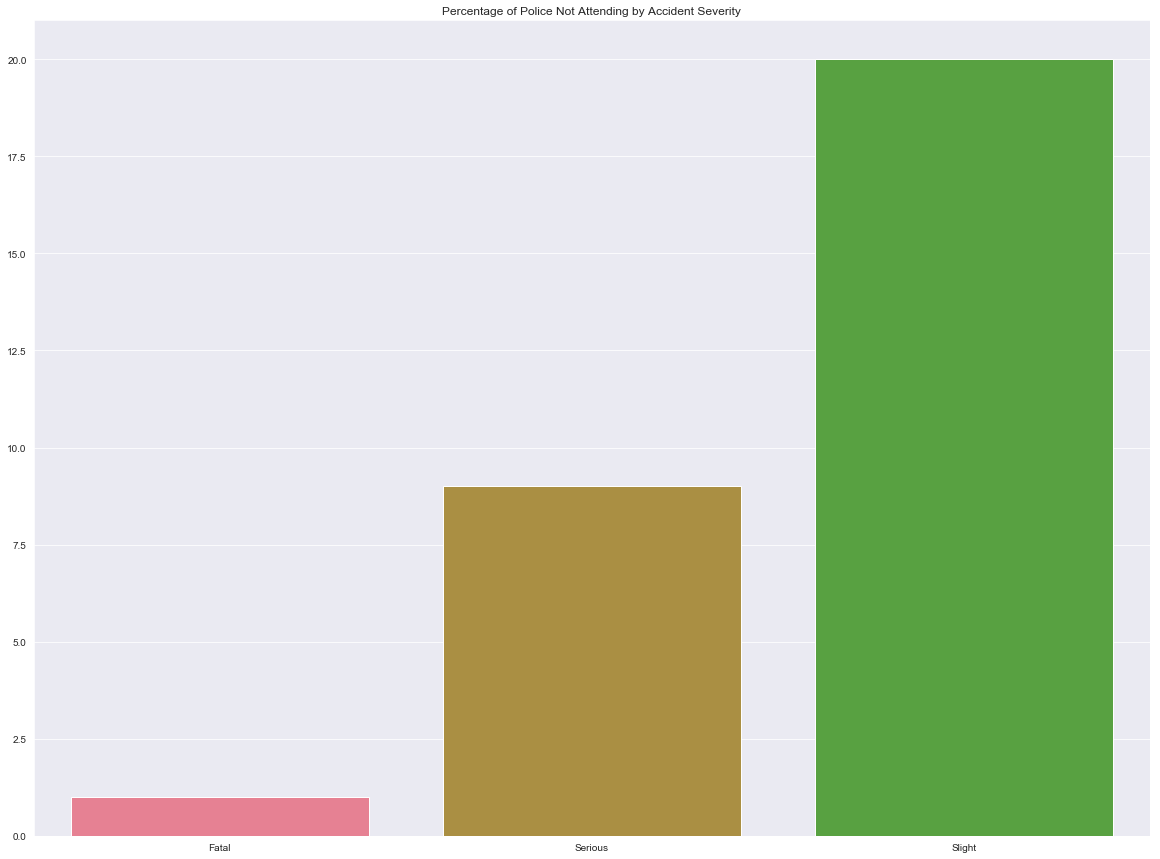

In [15]:
a=np.round((np.array(sever_by_attend.loc[
    sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(sever_by_attend.loc[
    sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(sever_by_attend.loc[
     sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=sever_by_attend.Accident_Severity.unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Accident Severity")

#### Number of Casualties 

Text(0.5, 1.0, 'Histograms of Number of Casualties Attended vs Not Attended')

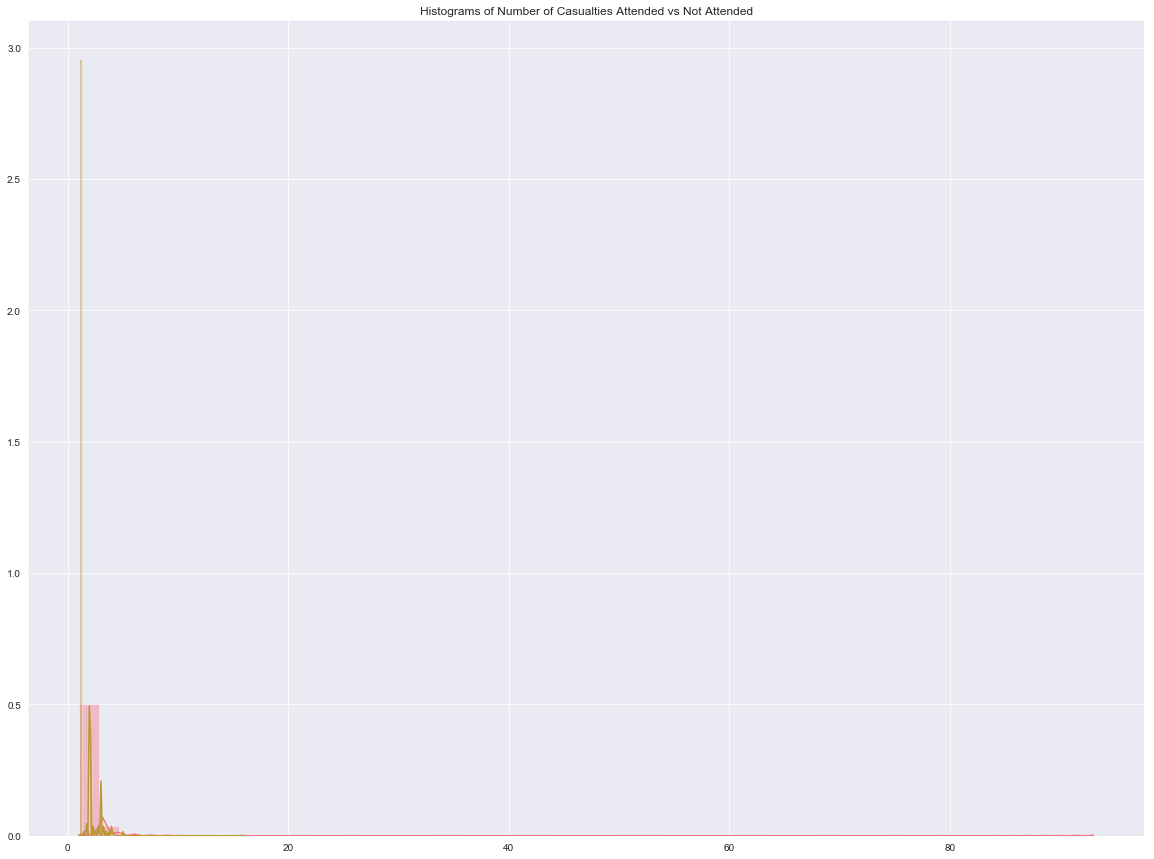

In [16]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Casualties']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Casualties']],bins=50,label='Not Attended')
plt.title('Histograms of Number of Casualties Attended vs Not Attended')

Text(0.5, 1.0, 'Zoomed Histograms of Number of Casualties Attended vs Not Attended')

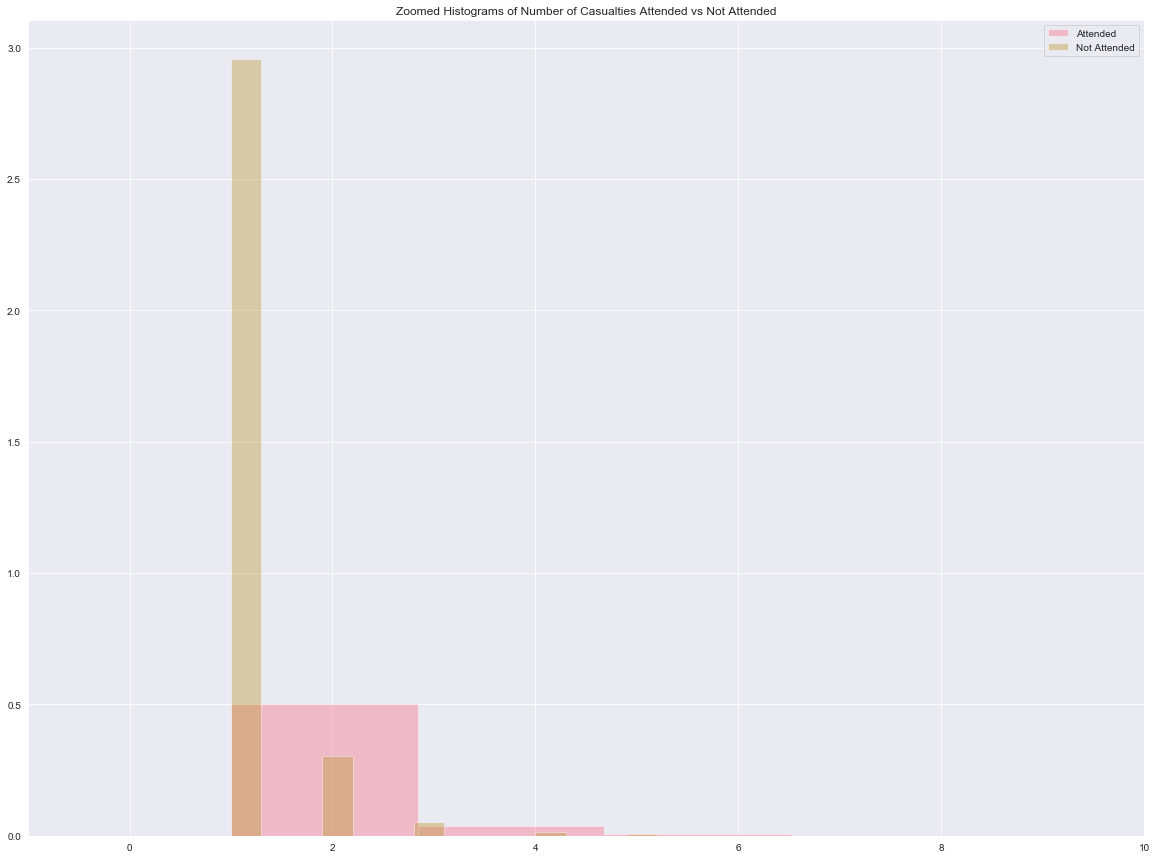

In [17]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Casualties']],norm_hist=True,bins=50,kde=False,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Casualties']],norm_hist=True,bins=50,kde=False,label='Not Attended')
plt.xlim(-1, 10)
plt.legend()
plt.title('Zoomed Histograms of Number of Casualties Attended vs Not Attended')

#### Number of Vehicles

Text(0.5, 1.0, 'Histograms of Number of Vehicles Attended vs Not Attended')

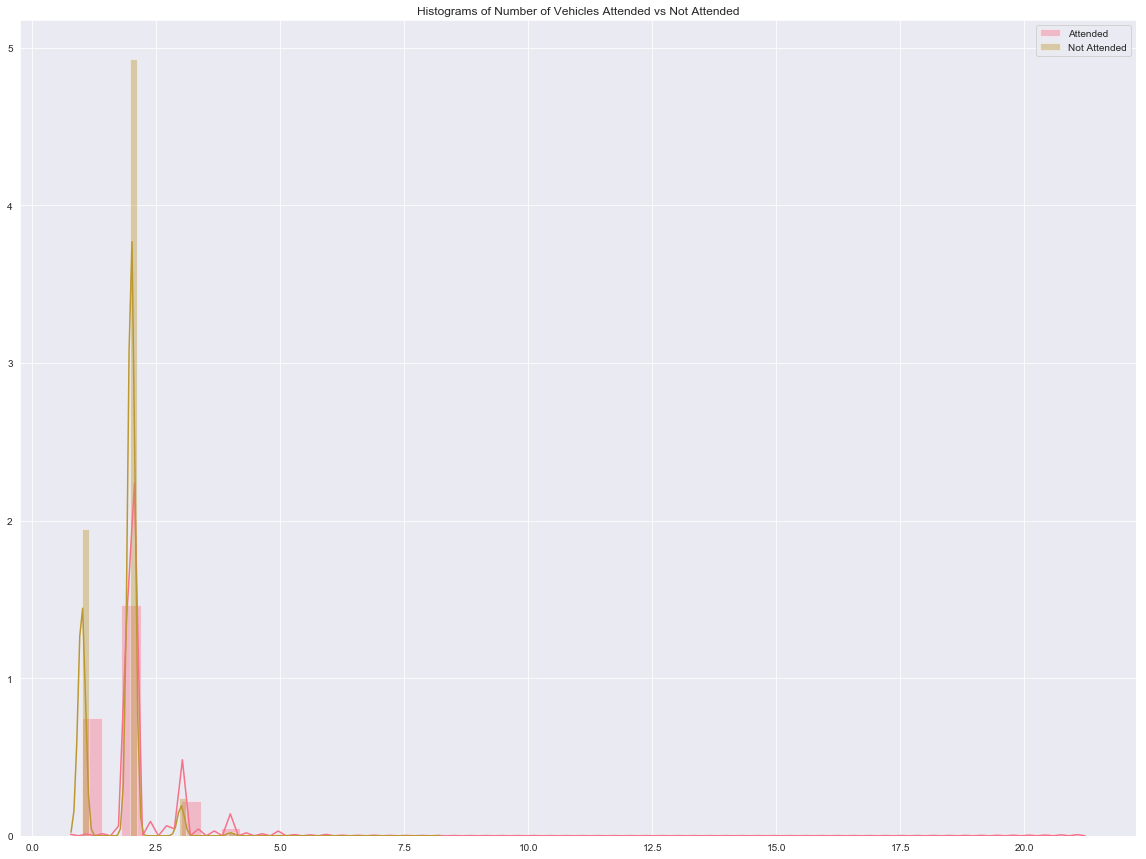

In [18]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Vehicles']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Vehicles']],bins=50,label='Not Attended')
plt.legend()
plt.title('Histograms of Number of Vehicles Attended vs Not Attended')

Text(0.5, 1.0, 'Zoomed Histograms of Number of Vehicles Attended vs Not Attended')

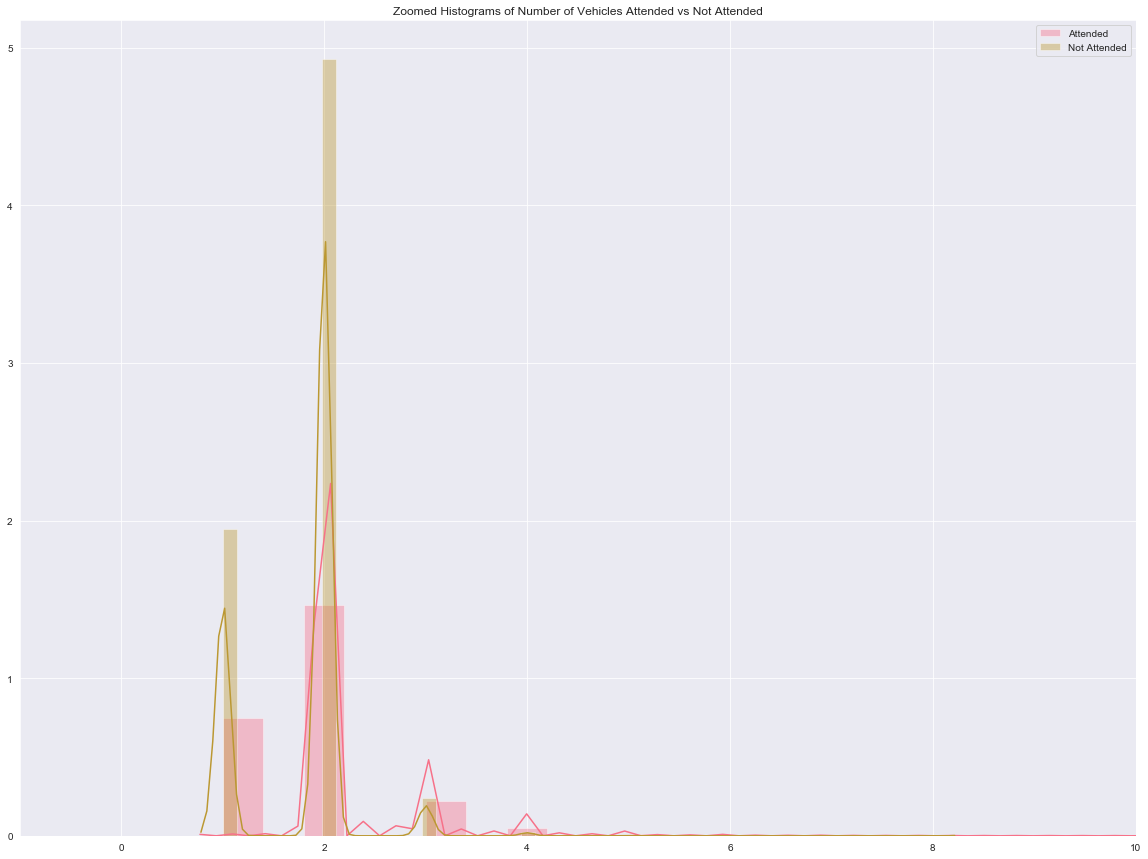

In [19]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Vehicles']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Vehicles']],bins=50,label='Not Attended')
plt.xlim(-1, 10)
plt.legend()
plt.title('Zoomed Histograms of Number of Vehicles Attended vs Not Attended')

#### 1st_Road_Class

,1st_Road_Class,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,A,NO,11024
1,A,YES,56804
2,A(M),NO,30
3,A(M),YES,354
4,B,NO,3254
5,B,YES,15319
6,C,NO,2380
7,C,YES,10589
8,Motorway,NO,389
9,Motorway,YES,4857


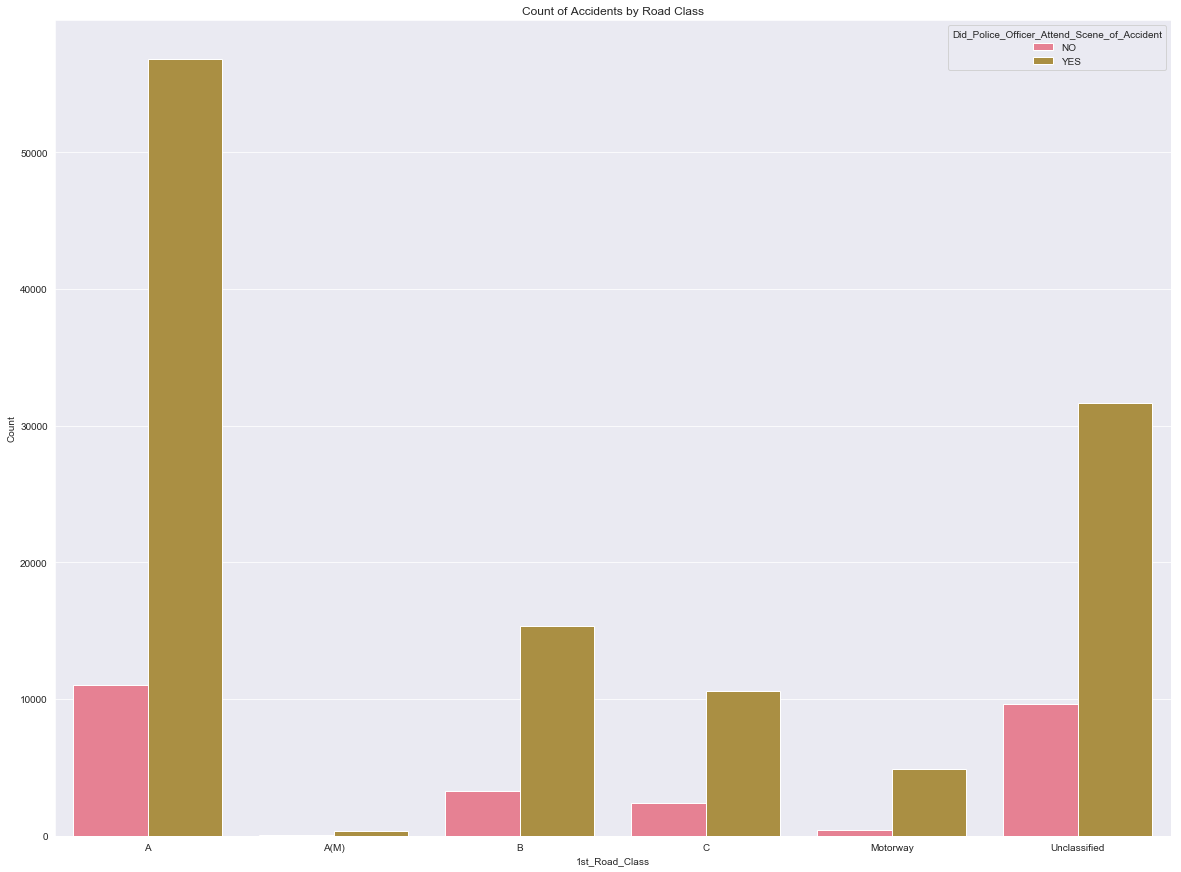

In [20]:
road_by_attend=df_acc.replace({'1st_Road_Class':
                               {1:'Motorway',2:'A(M)',3:'A',4:'B',5:'C',6:'Unclassified'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['1st_Road_Class','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['1st_Road_Class','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='1st_Road_Class', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=road_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Class')

road_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Class')

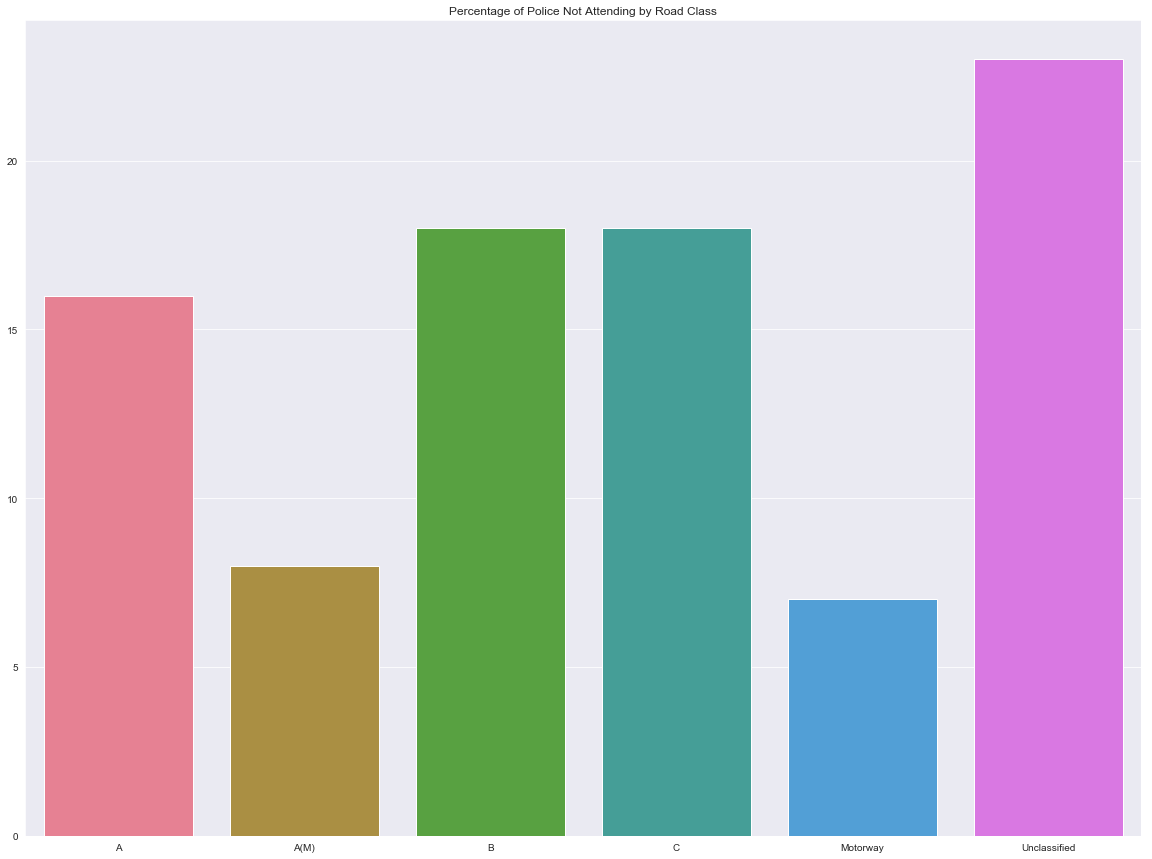

In [21]:
a=np.round((np.array(road_by_attend.loc[
    road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(road_by_attend.loc[
    road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(road_by_attend.loc[
     road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=road_by_attend['1st_Road_Class'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Class")

#### Road_Type

,Road_Type,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Dual carriageway,NO,2664
1,Dual carriageway,YES,18159
2,One way street,NO,790
3,One way street,YES,2145
4,Roundabout,NO,2628
5,Roundabout,YES,7701
6,Single carriageway,NO,20187
7,Single carriageway,YES,90000
8,Slip road,NO,256
9,Slip road,YES,1286


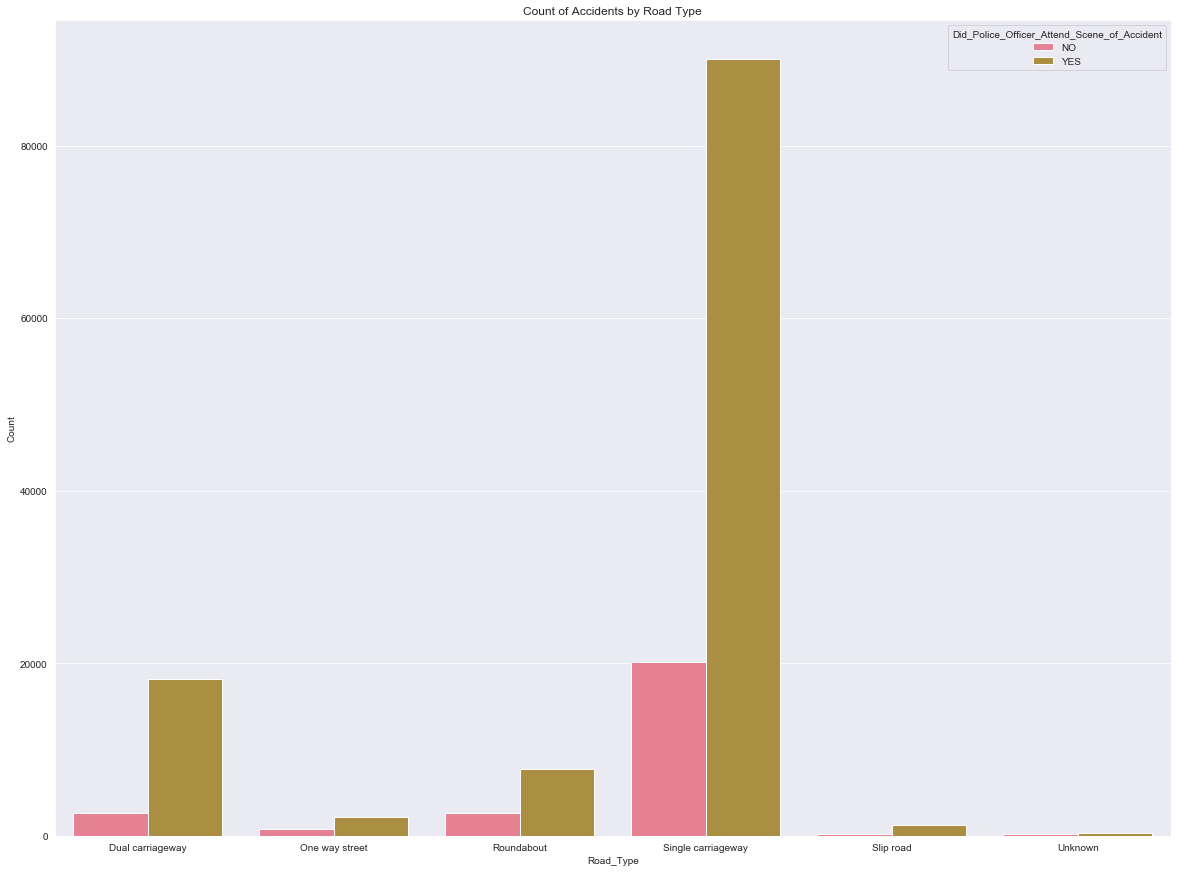

In [22]:
roadtype_by_attend=df_acc.replace({'Road_Type':
                               {1:'Roundabout',2:'One way street',3:'Dual carriageway',
                                6:'Single carriageway',7:'Slip road',9:'Unknown',
                                12:'One way street/Slip road'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Road_Type','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Road_Type','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Road_Type', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Type')
roadtype_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Type')

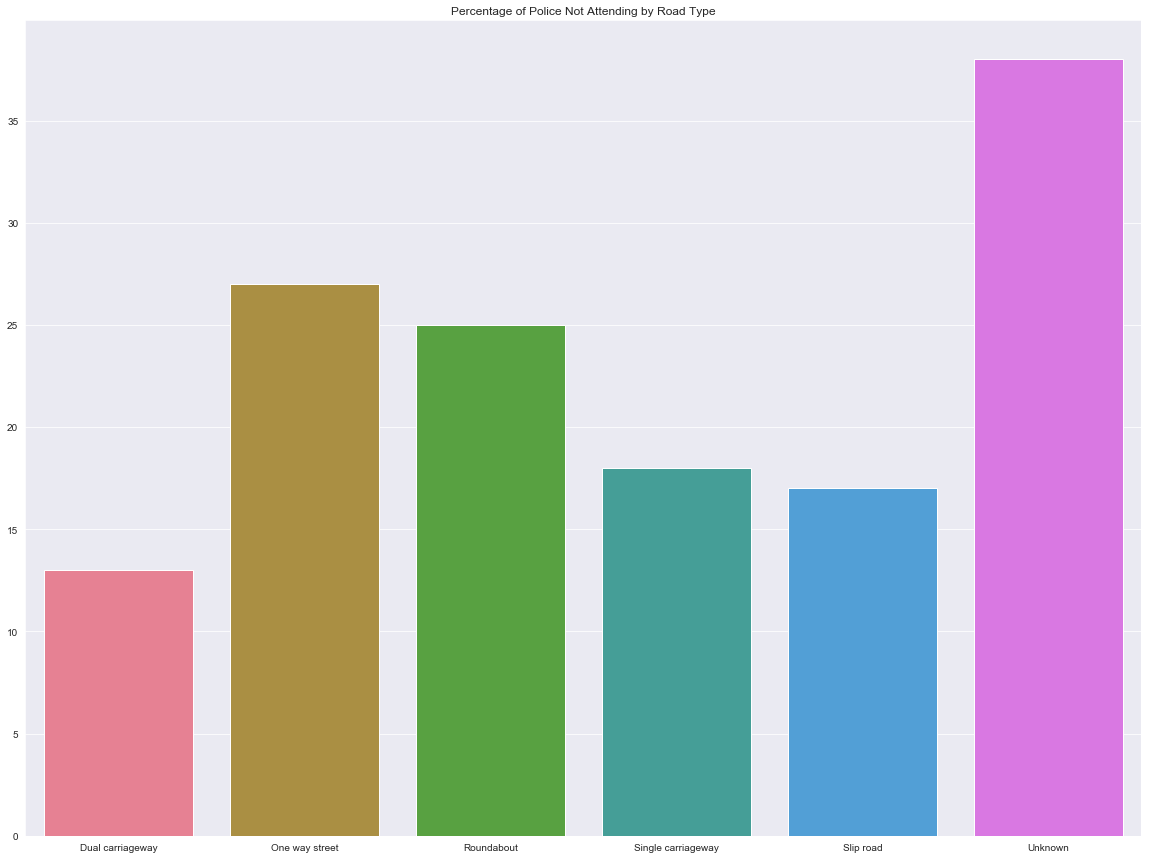

In [23]:
a=np.round((np.array(roadtype_by_attend.loc[
    roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_attend.loc[
    roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_attend.loc[
     roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_attend['Road_Type'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Type")

#### Speed Limit

Text(0.5, 1.0, 'Histograms of Number of Accidents for Each Speed Limit Attended vs Not Attended')

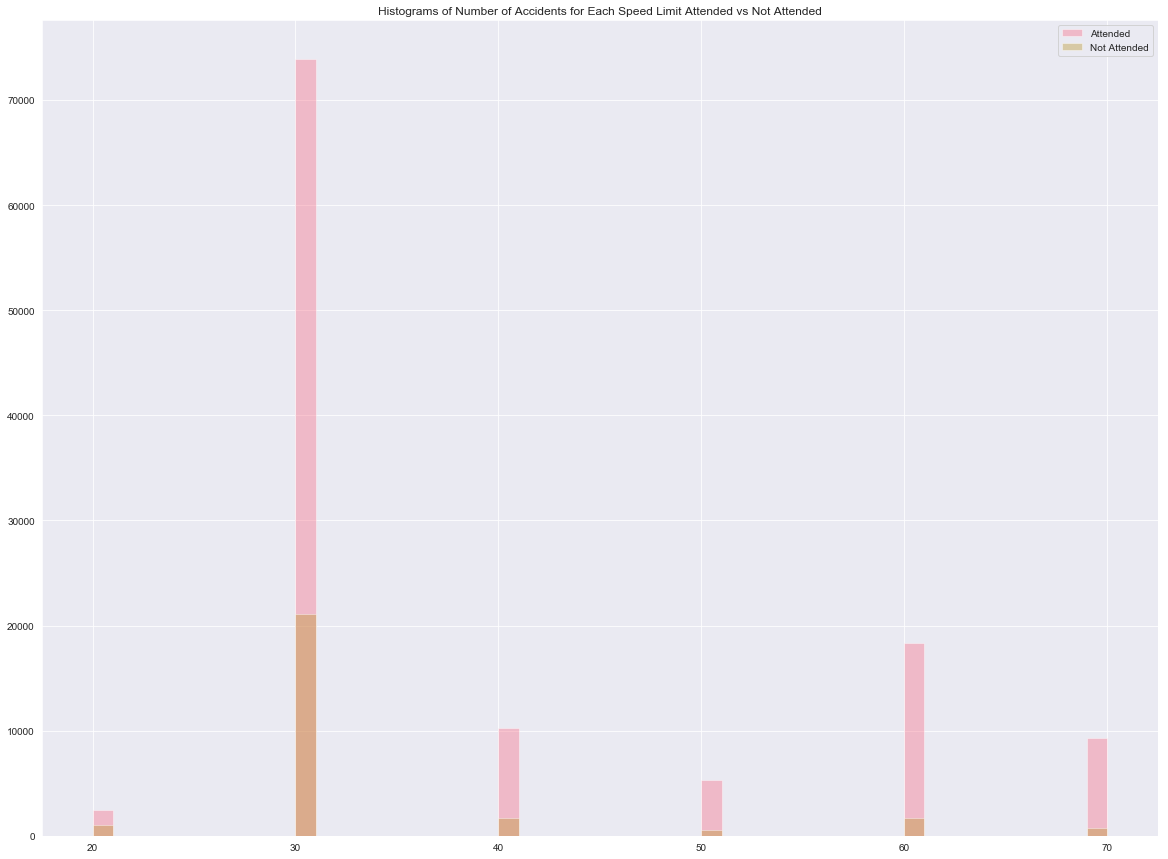

In [24]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Speed_limit']],bins=50,kde=False,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Speed_limit']],bins=50,kde=False,label='Not Attended')
# plt.xlim(-1, 10)

plt.legend()
plt.title('Histograms of Number of Accidents for Each Speed Limit Attended vs Not Attended')

In [25]:
df_acc.Speed_limit.unique()

array([30, 40, 20, 50, 70, 60])

,Speed_limit,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,20,NO,980
1,20,YES,2438
2,30,NO,21110
3,30,YES,73887
4,40,NO,1727
5,40,YES,10290
6,50,NO,511
7,50,YES,5286
8,60,NO,1662
9,60,YES,18354


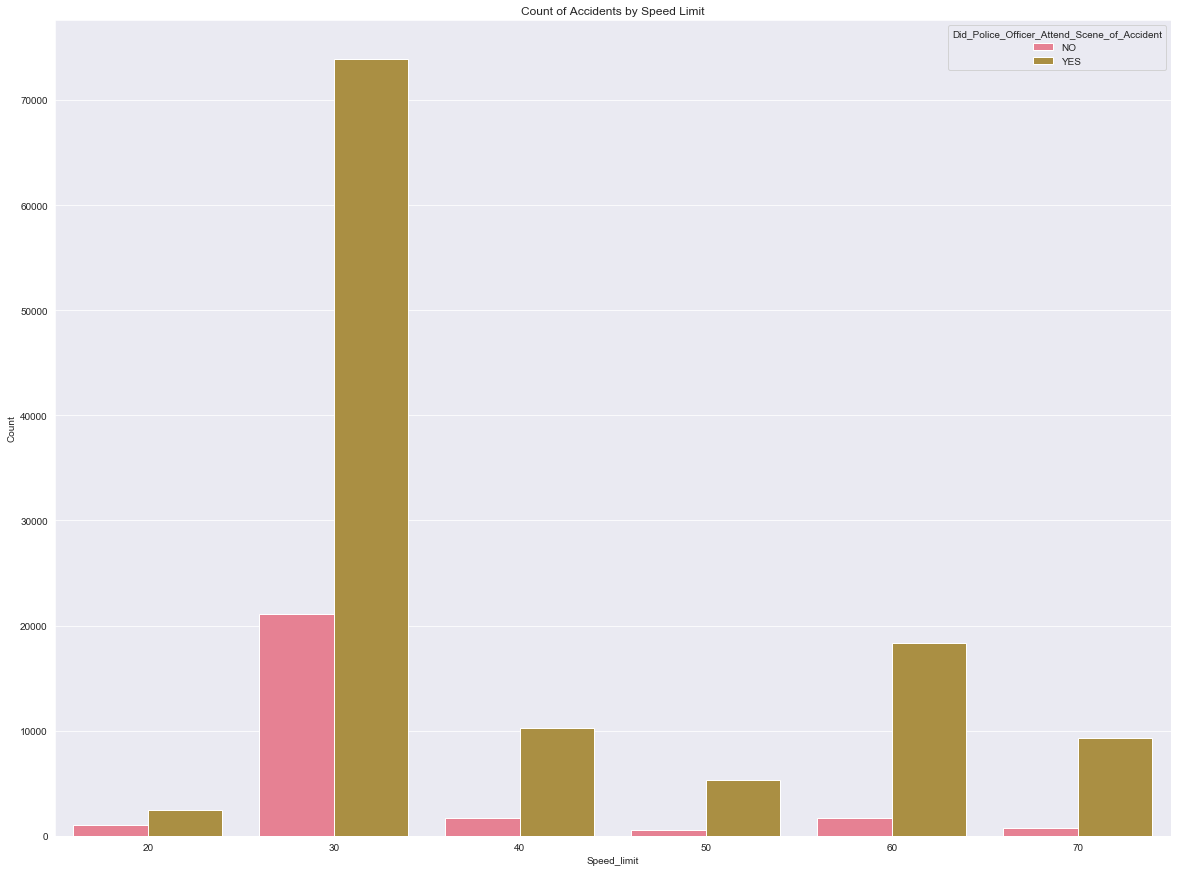

In [26]:
roadtype_by_limit=df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Speed_limit','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Speed_limit','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Speed_limit', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_limit)
plt.ylabel("Count")
plt.title('Count of Accidents by Speed Limit')
roadtype_by_limit

Text(0.5, 1.0, 'Percentage of Police Not Attending by Speed Limit')

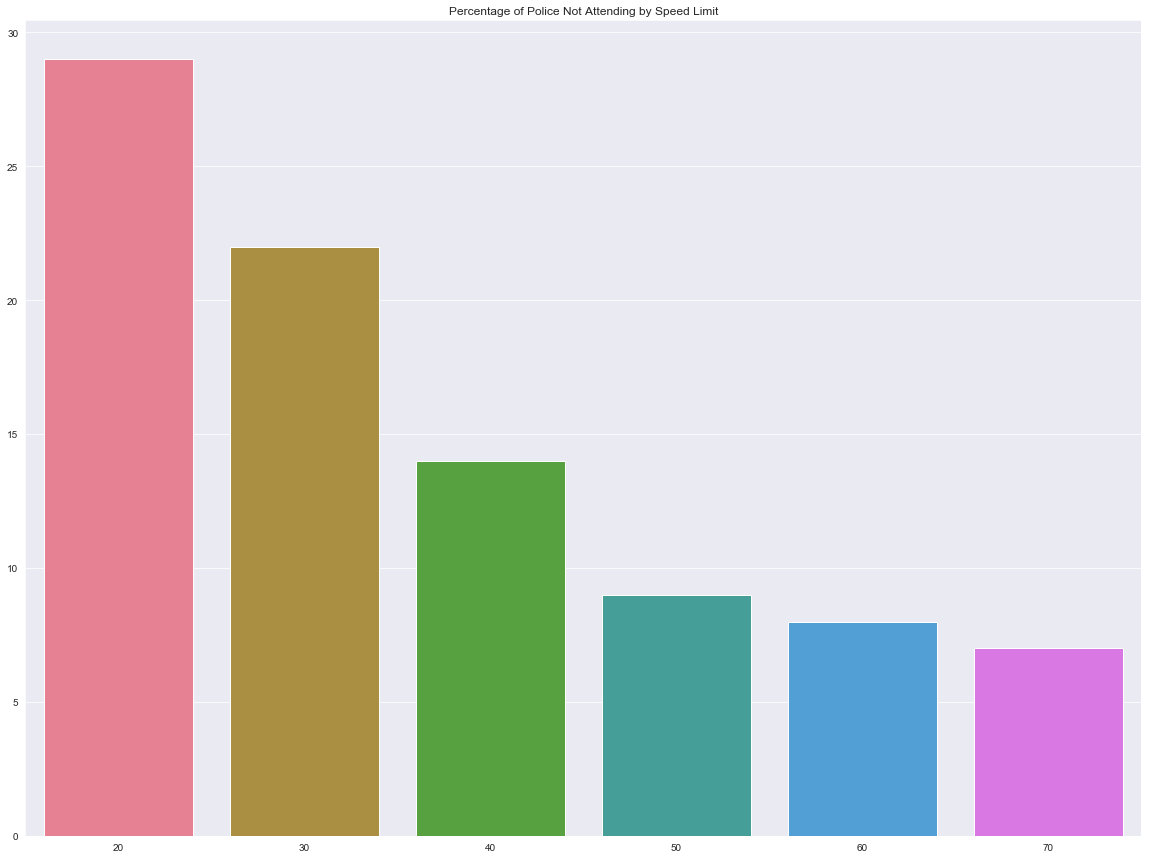

In [27]:
a=np.round((np.array(roadtype_by_limit.loc[
    roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_limit.loc[
    roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_limit.loc[
     roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_limit['Speed_limit'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Speed Limit")

#### Junction Detail

,Junction_Detail,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Crossroads,NO,2320
1,Crossroads,YES,12266
2,Mini-roundabout,NO,459
3,Mini-roundabout,YES,1497
4,More than 4 arms (not roundabout),NO,187
5,More than 4 arms (not roundabout),YES,830
6,Not at junction or within 20 metres,NO,9199
7,Not at junction or within 20 metres,YES,47211
8,Other junction,NO,547
9,Other junction,YES,2578


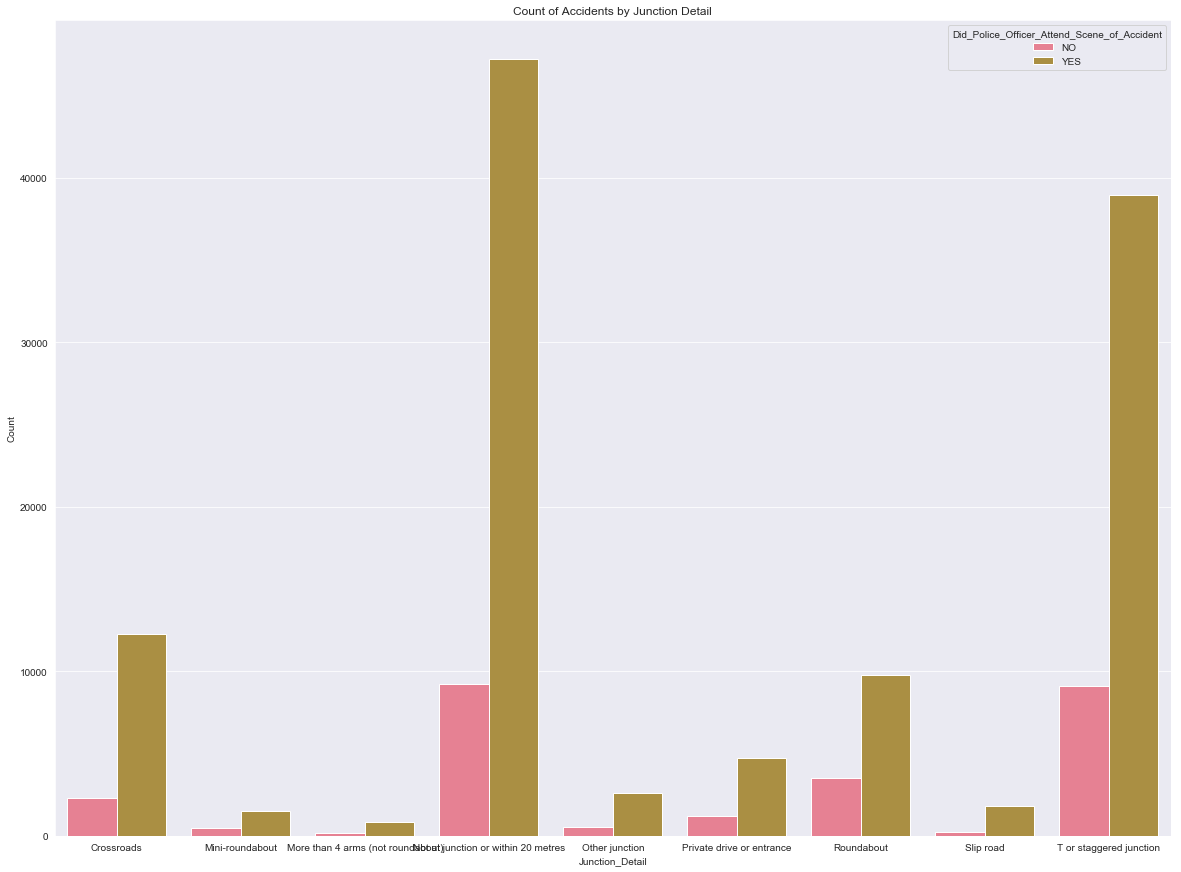

In [28]:
roadtype_by_jd=df_acc.replace({'Junction_Detail':
                               {0:'Not at junction or within 20 metres',
                                1:'Roundabout',
                                2:'Mini-roundabout',
                                3:'T or staggered junction',
                                5:'Slip road',
                                6:'Crossroads',
                                7:'More than 4 arms (not roundabout)',
                                8:'Private drive or entrance',
                                9:'Other junction'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Junction_Detail','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Junction_Detail','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Junction_Detail', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_jd)
plt.ylabel("Count")
plt.title('Count of Accidents by Junction Detail')
roadtype_by_jd

Text(0.5, 1.0, 'Percentage of Police Not Attending by Junction Detail')

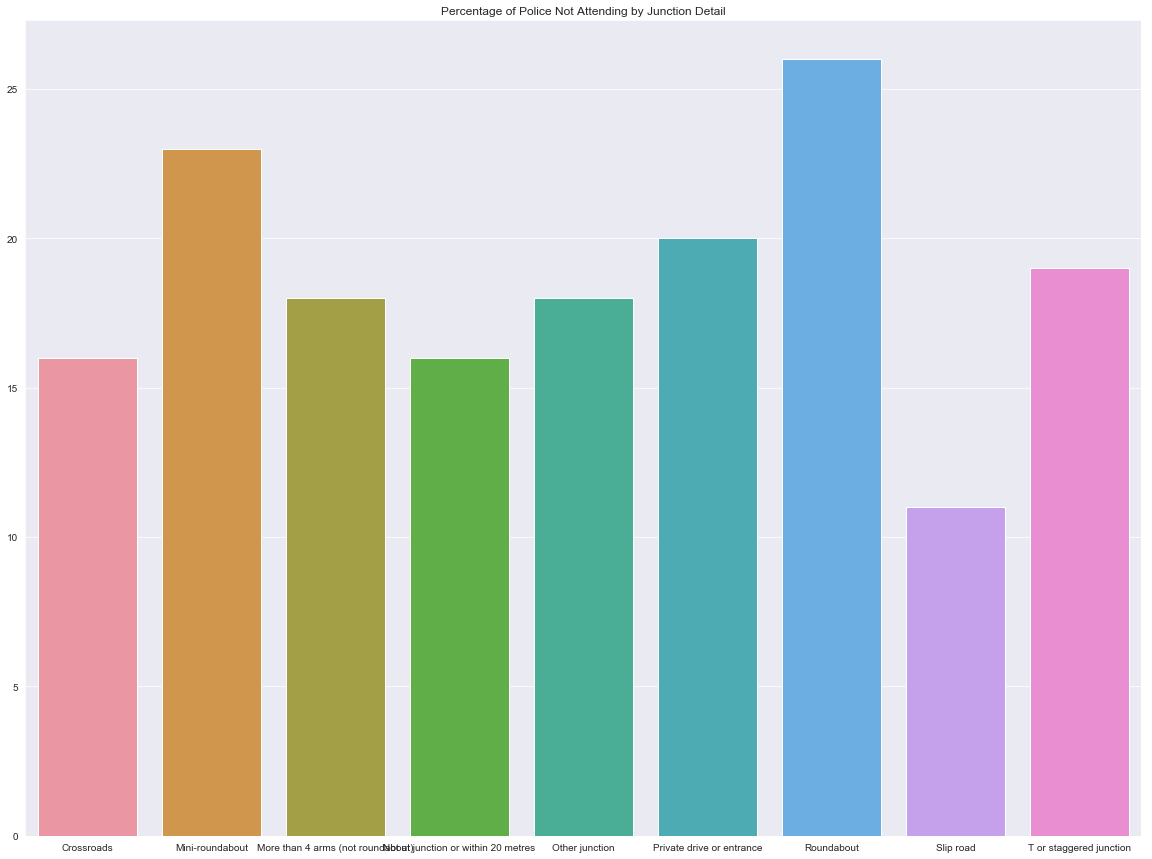

In [29]:
a=np.round((np.array(roadtype_by_jd.loc[
    roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_jd.loc[
    roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_jd.loc[
     roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_jd['Junction_Detail'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Junction Detail")

#### Junction Control

,Junction_Control,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Authorised person,NO,41
1,Authorised person,YES,159
2,Auto traffic signal,NO,3130
3,Auto traffic signal,YES,12143
4,Give way or uncontrolled,NO,14210
5,Give way or uncontrolled,YES,59529
6,Stop sign,NO,130
7,Stop sign,YES,513


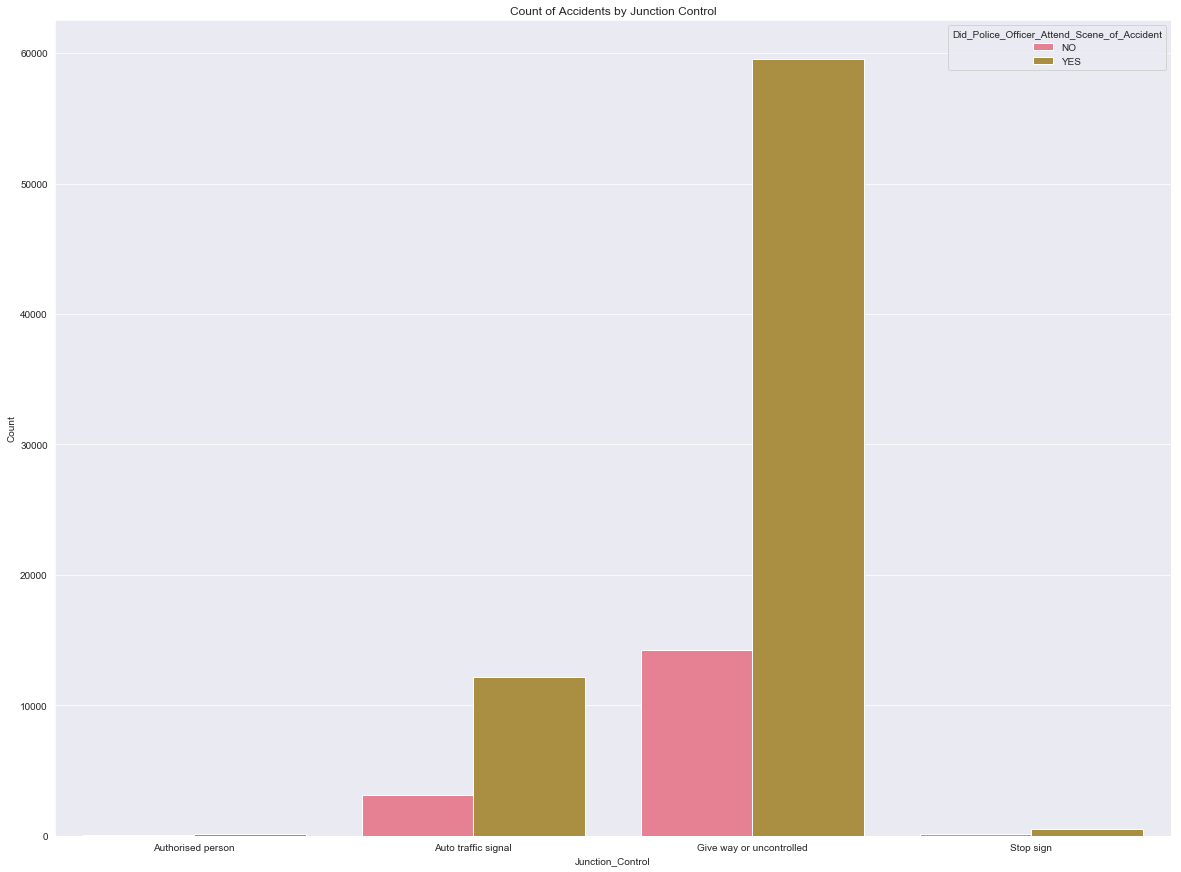

In [30]:
roadtype_by_jc=df_acc.replace({'Junction_Control':
                               {0:'Not at junction or within 20 metres',
                                1:'Authorised person',
                                2:'Auto traffic signal',
                                3:'Stop sign',
                                4:'Give way or uncontrolled',
                                -1:'Data missing or out of range'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Junction_Control','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Junction_Control','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Junction_Control', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_jc)
plt.ylabel("Count")
plt.title('Count of Accidents by Junction Control')
roadtype_by_jc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Junction Control')

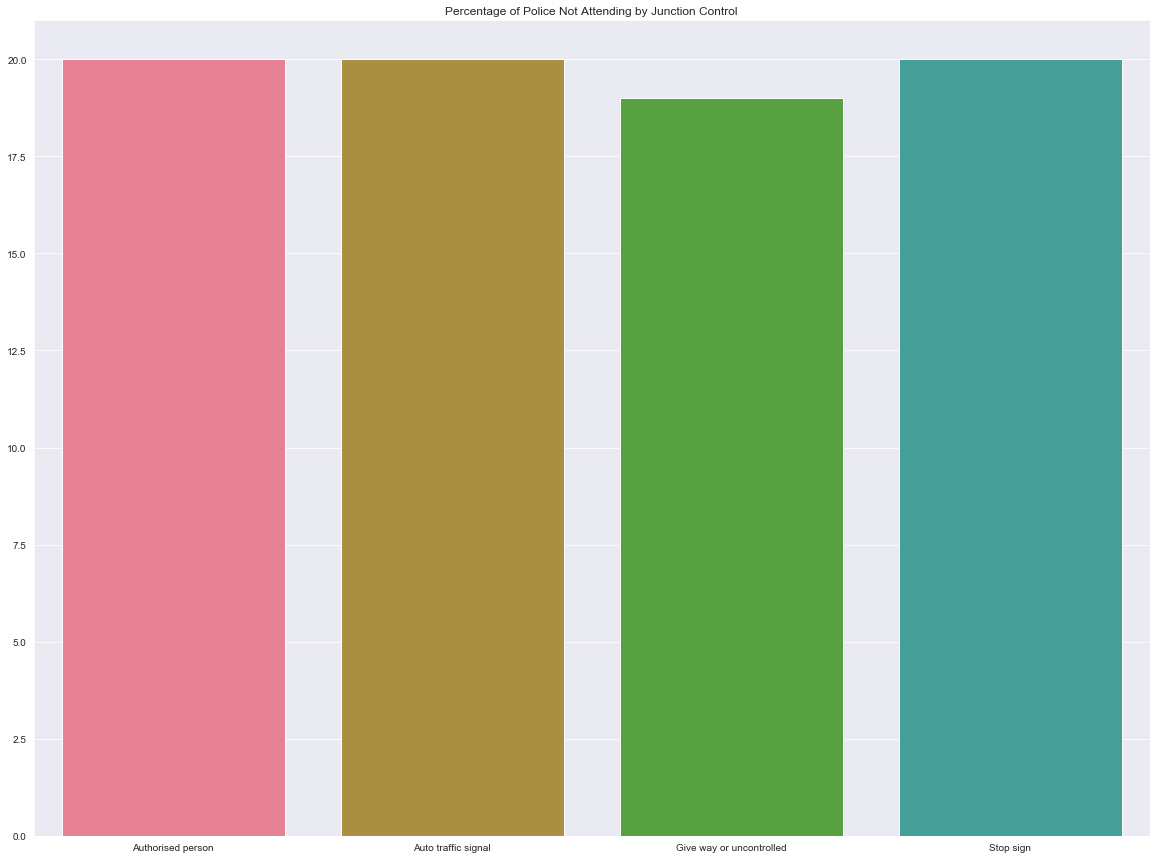

In [31]:
a=np.round((np.array(roadtype_by_jc.loc[
    roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_jc.loc[
    roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_jc.loc[
     roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_jc['Junction_Control'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Junction Control")

#### Light Conditions

,Light_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Darkness - lighting unknown,NO,659
1,Darkness - lighting unknown,YES,1072
2,Darkness - lights lit,NO,4668
3,Darkness - lights lit,YES,23781
4,Darkness - lights unlit,NO,121
5,Darkness - lights unlit,YES,751
6,Darkness - no lighting,NO,419
7,Darkness - no lighting,YES,6780
8,Daylight,NO,20848
9,Daylight,YES,87223


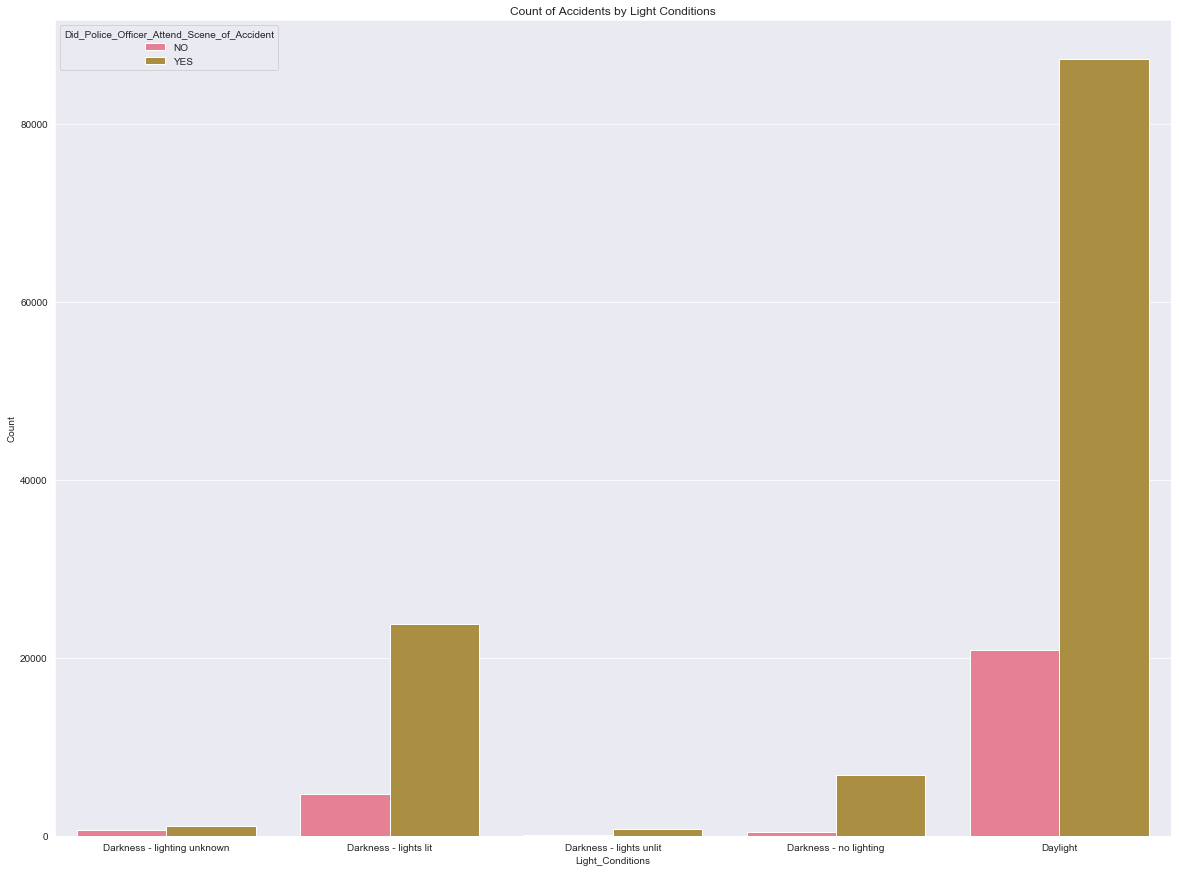

In [32]:
roadtype_by_lc=df_acc.replace({'Light_Conditions':
                               {1:'Daylight',
                                4:'Darkness - lights lit',
                                5:'Darkness - lights unlit',
                                6:'Darkness - no lighting',
                                7:'Darkness - lighting unknown'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Light_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Light_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Light_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_lc)
plt.ylabel("Count")
plt.title('Count of Accidents by Light Conditions')
roadtype_by_lc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Light Conditions')

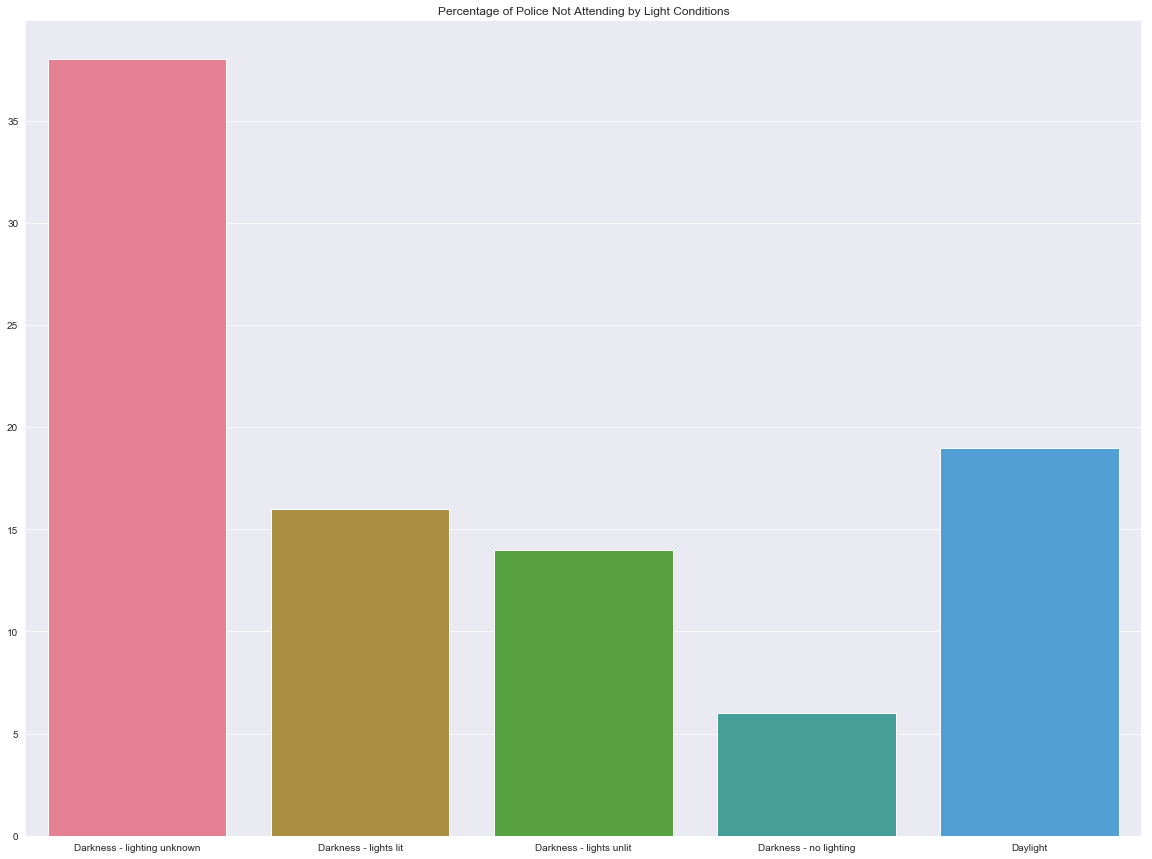

In [33]:
a=np.round((np.array(roadtype_by_lc.loc[
    roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_lc.loc[
    roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_lc.loc[
     roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_lc['Light_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Light Conditions")

#### Weather Conditions

,Weather_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Fine + high winds,NO,215
1,Fine + high winds,YES,1360
2,Fine no high winds,NO,21690
3,Fine no high winds,YES,97189
4,Fog or mist,NO,86
5,Fog or mist,YES,667
6,Other,NO,427
7,Other,YES,1905
8,Raining + high winds,NO,295
9,Raining + high winds,YES,2038


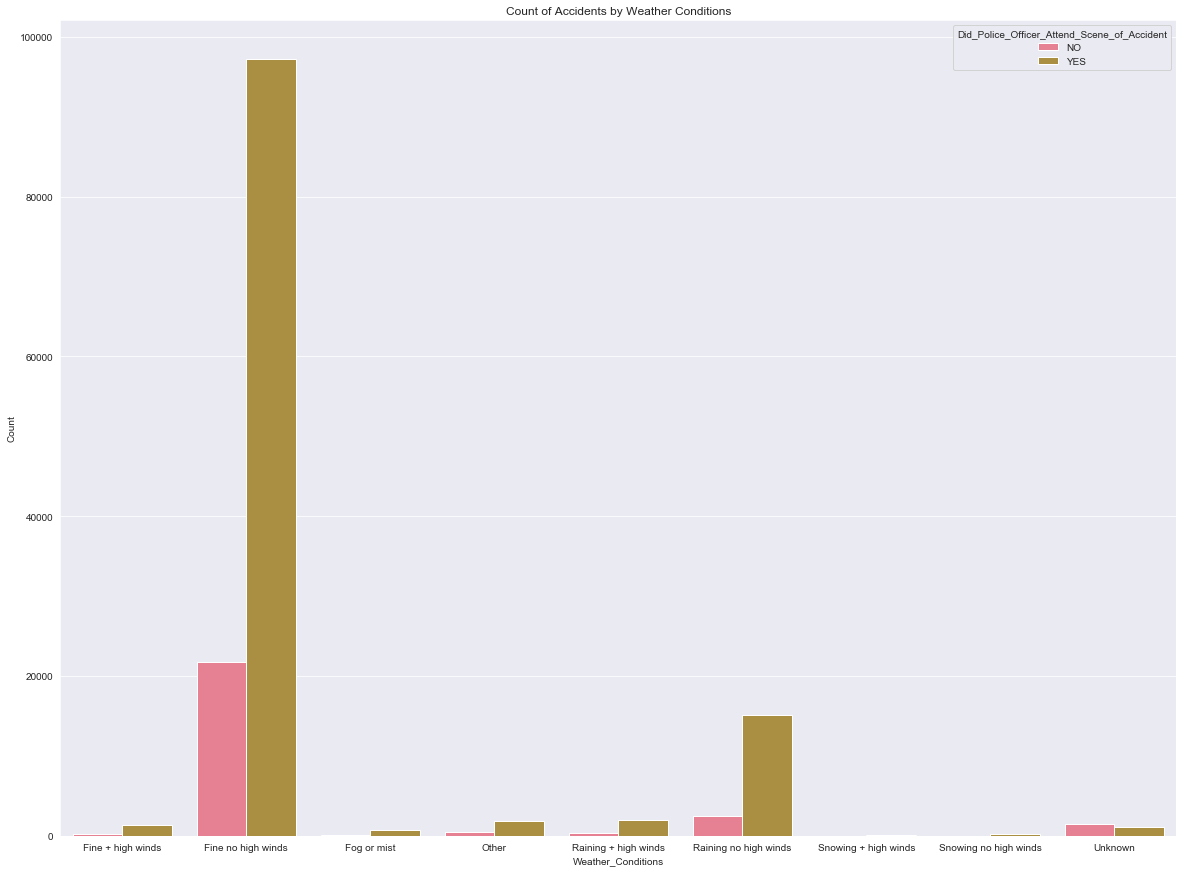

In [34]:
roadtype_by_wc=df_acc.replace({'Weather_Conditions':
                               {1:'Fine no high winds',
                                2:'Raining no high winds',
                                3:'Snowing no high winds',
                                4:'Fine + high winds',
                                5:'Raining + high winds',
                                6:'Snowing + high winds',
                                7:'Fog or mist',
                                8:'Other',
                                9:'Unknown'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Weather_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Weather_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Weather_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_wc)
plt.ylabel("Count")
plt.title('Count of Accidents by Weather Conditions')
roadtype_by_wc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Weather Conditions')

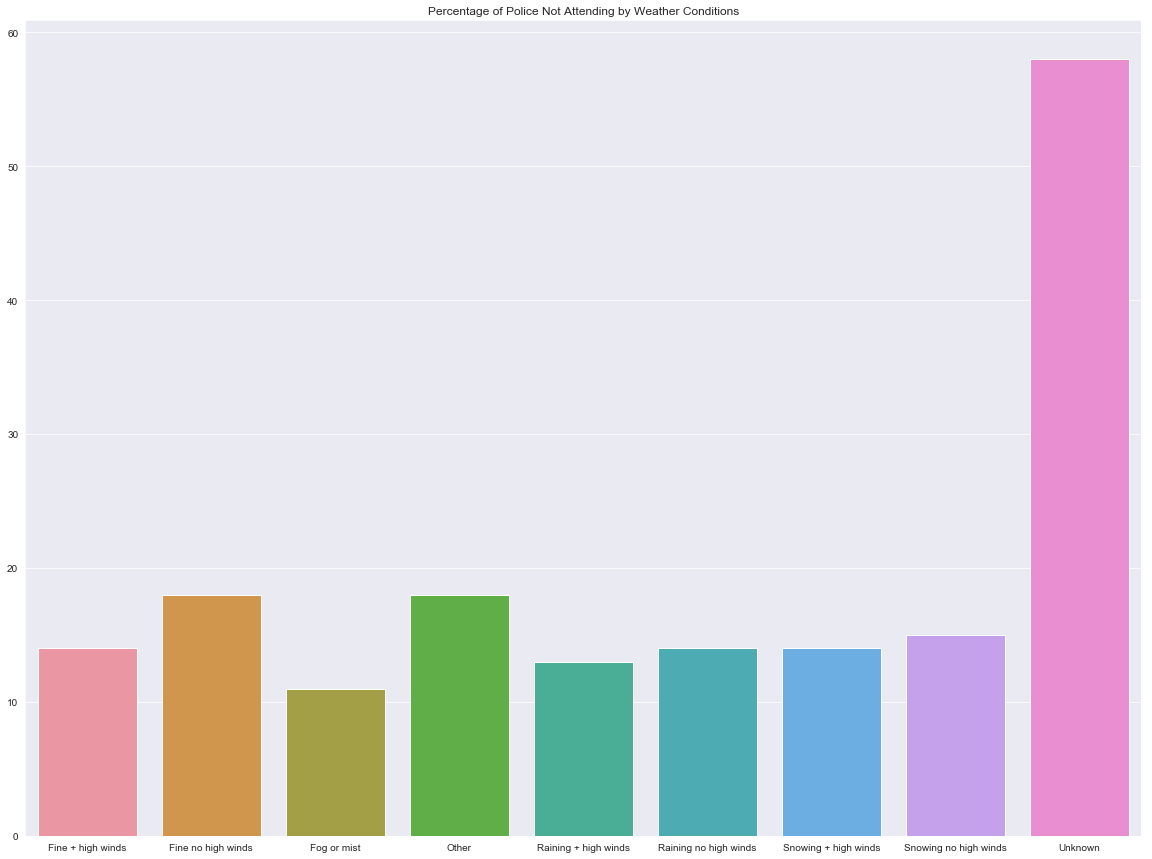

In [35]:
a=np.round((np.array(roadtype_by_wc.loc[
    roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_wc.loc[
    roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_wc.loc[
     roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_wc['Weather_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Weather Conditions")

Possible data bleed thorugh the Unkown factor ? Could be that the condition is not recorded when the police did not attend?

#### Road Surface Conditions

,Road_Surface_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Dry,NO,20578
1,Dry,YES,81441
2,Flood over 3cm. deep,NO,17
3,Flood over 3cm. deep,YES,245
4,Frost or ice,NO,148
5,Frost or ice,YES,1544
6,Snow,NO,36
7,Snow,YES,170
8,Wet or damp,NO,5758
9,Wet or damp,YES,36163


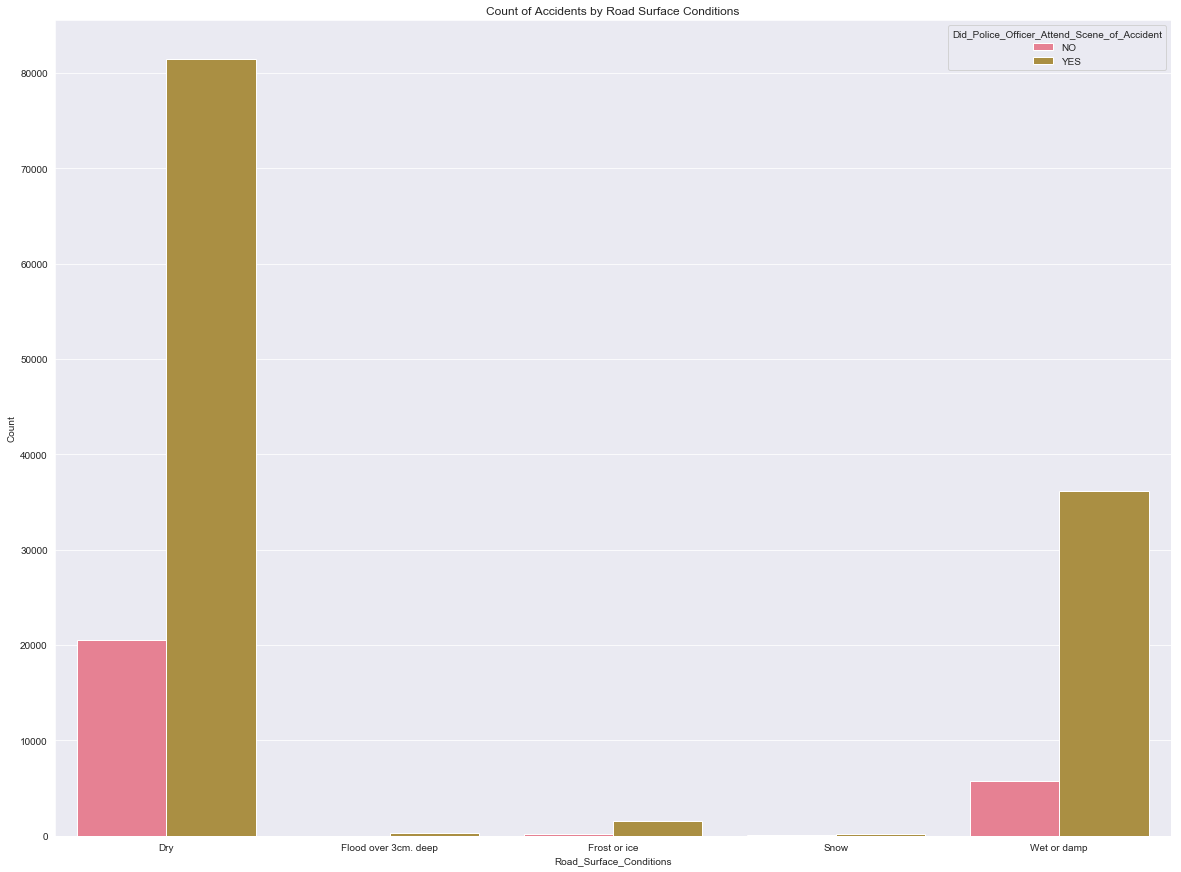

In [36]:
roadtype_by_rsc=df_acc.replace({'Road_Surface_Conditions':
                               {1:'Dry',
                                2:'Wet or damp',
                                3:'Snow',
                                4:'Frost or ice',
                                5:'Flood over 3cm. deep',
                                6:'Oil or diesel',
                                7:'Mud'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Road_Surface_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Road_Surface_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Road_Surface_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_rsc)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Surface Conditions')
roadtype_by_rsc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Surface Conditions')

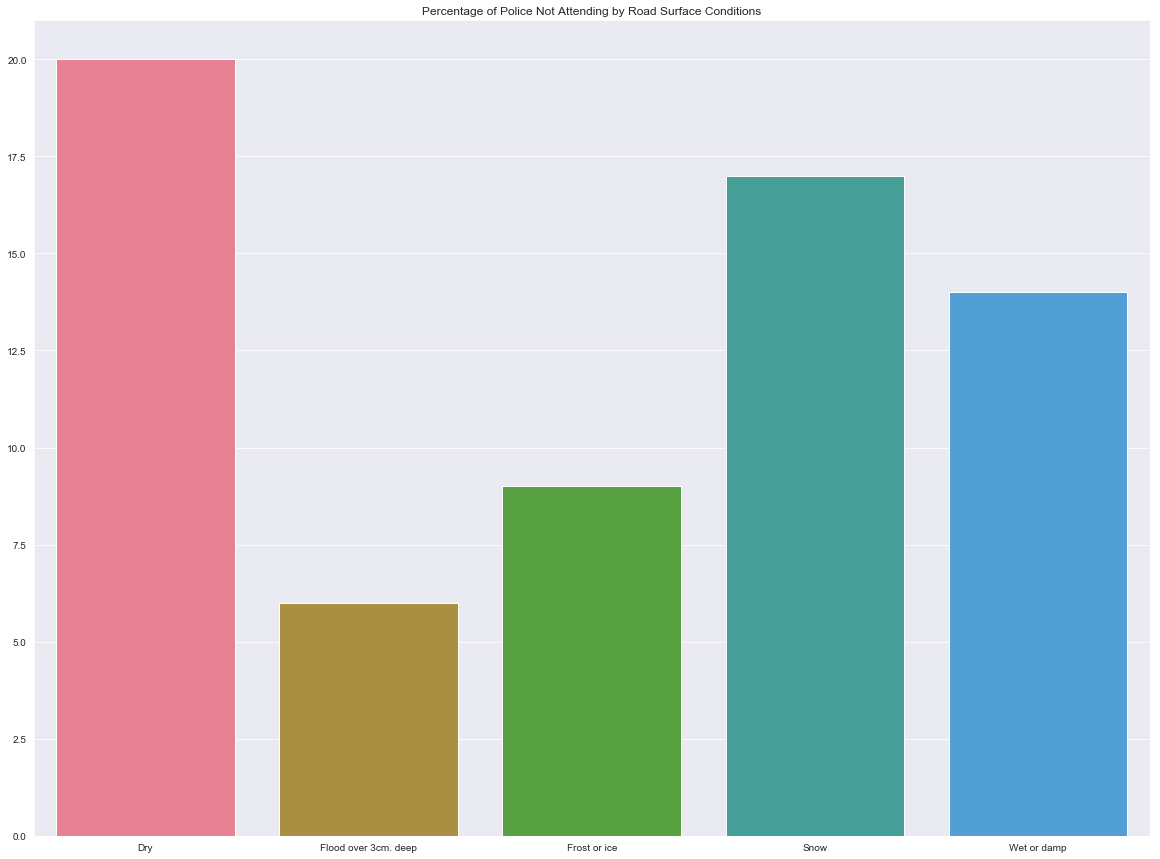

In [37]:
a=np.round((np.array(roadtype_by_rsc.loc[
    roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_rsc.loc[
    roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_rsc.loc[
     roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_rsc['Road_Surface_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Surface Conditions")

#### Time

Text(0.5, 1.0, 'Accidents per Month')

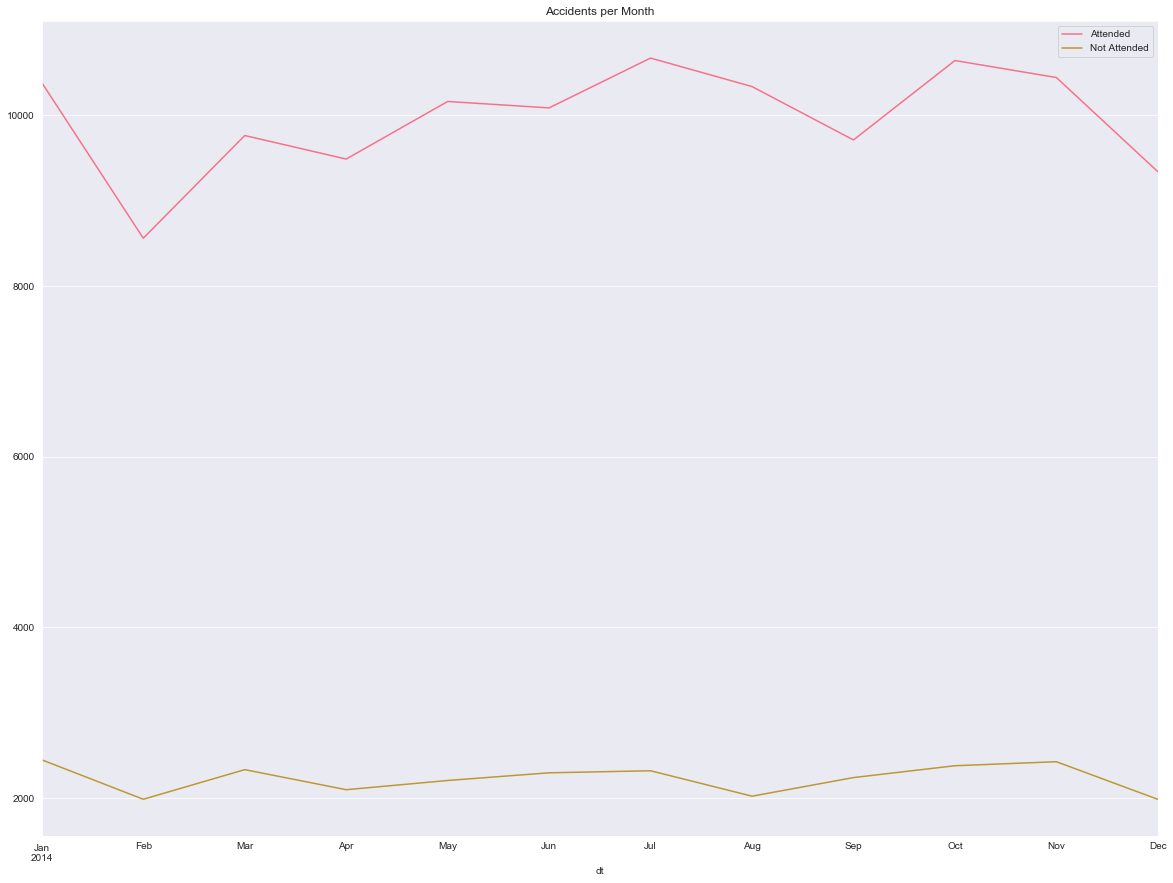

In [38]:
plt.figure(2, figsize=(20,15))
# df_acc.set_index('dt').resample('M').size().plot(label='Accidents per Month')
df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident==1
      ].set_index('dt').resample('M').size().plot(label='Attended')
df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident==0
      ].set_index('dt').resample('M').size().plot(label='Not Attended')
# sns.lineplot(x=df_acc_res_m.index,y= label='Accidents per Month'
#                             ,hue ='Did_Police_Officer_Attend_Scene_of_Accident')
plt.legend()
plt.title('Accidents per Month')
# df_acc_res_m

Text(0.5, 1.0, 'Accidents per Day')

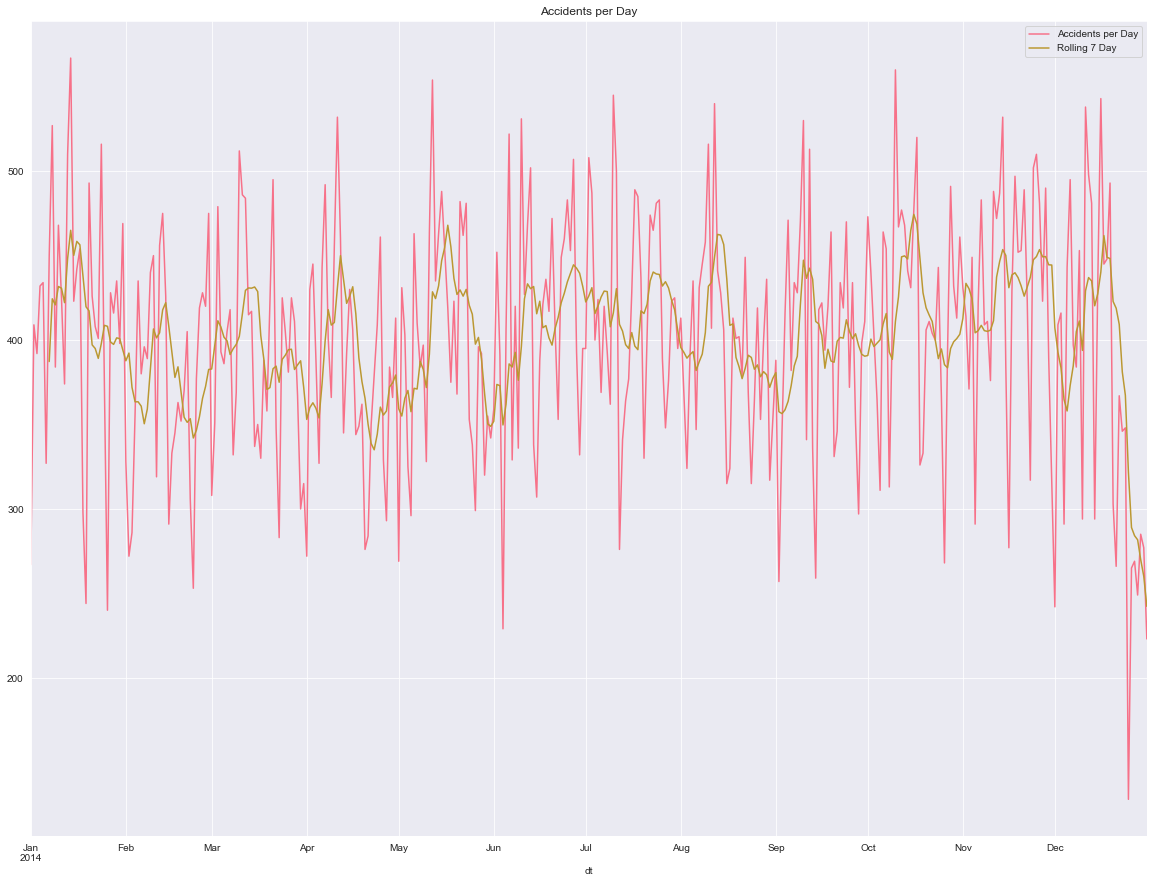

In [39]:
plt.figure(2, figsize=(20,15))
df_acc.set_index('dt').resample('D').size().plot(label='Accidents per Day')
df_acc.set_index('dt').resample('D').size().rolling(window=7).mean()\
                           .plot(label='Rolling 7 Day')
plt.legend()
plt.title('Accidents per Day')

### Checking Variable Relations

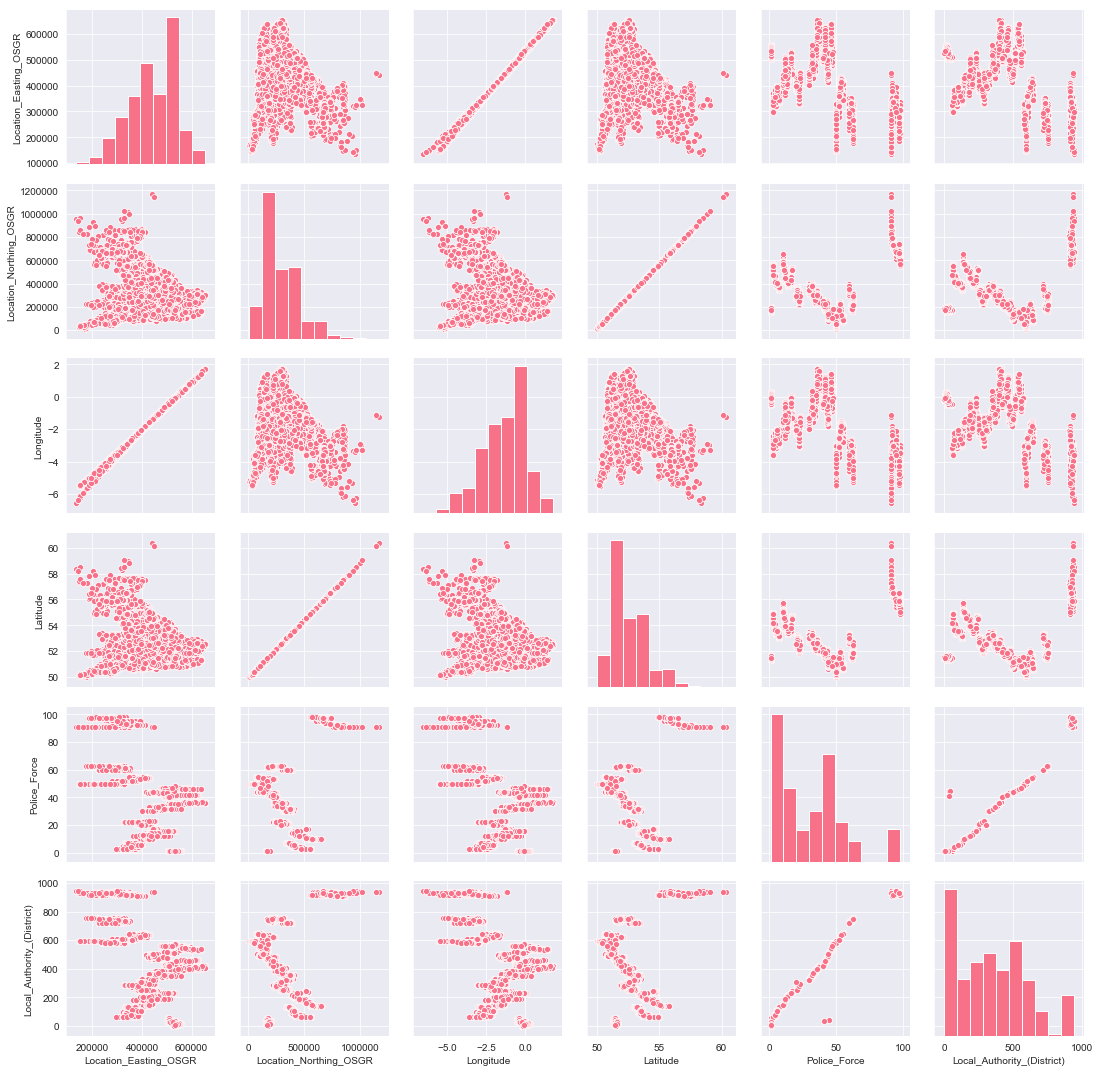

In [40]:
sns.pairplot(data=df_acc[['Location_Easting_OSGR', 
                            'Location_Northing_OSGR', 
                            'Longitude',
                            'Latitude',  
                            'Police_Force', 
                            'Local_Authority_(District)', 
                            'Local_Authority_(Highway)', 
                            'LSOA_of_Accident_Location',
                            ]].sample(frac = 0.1))

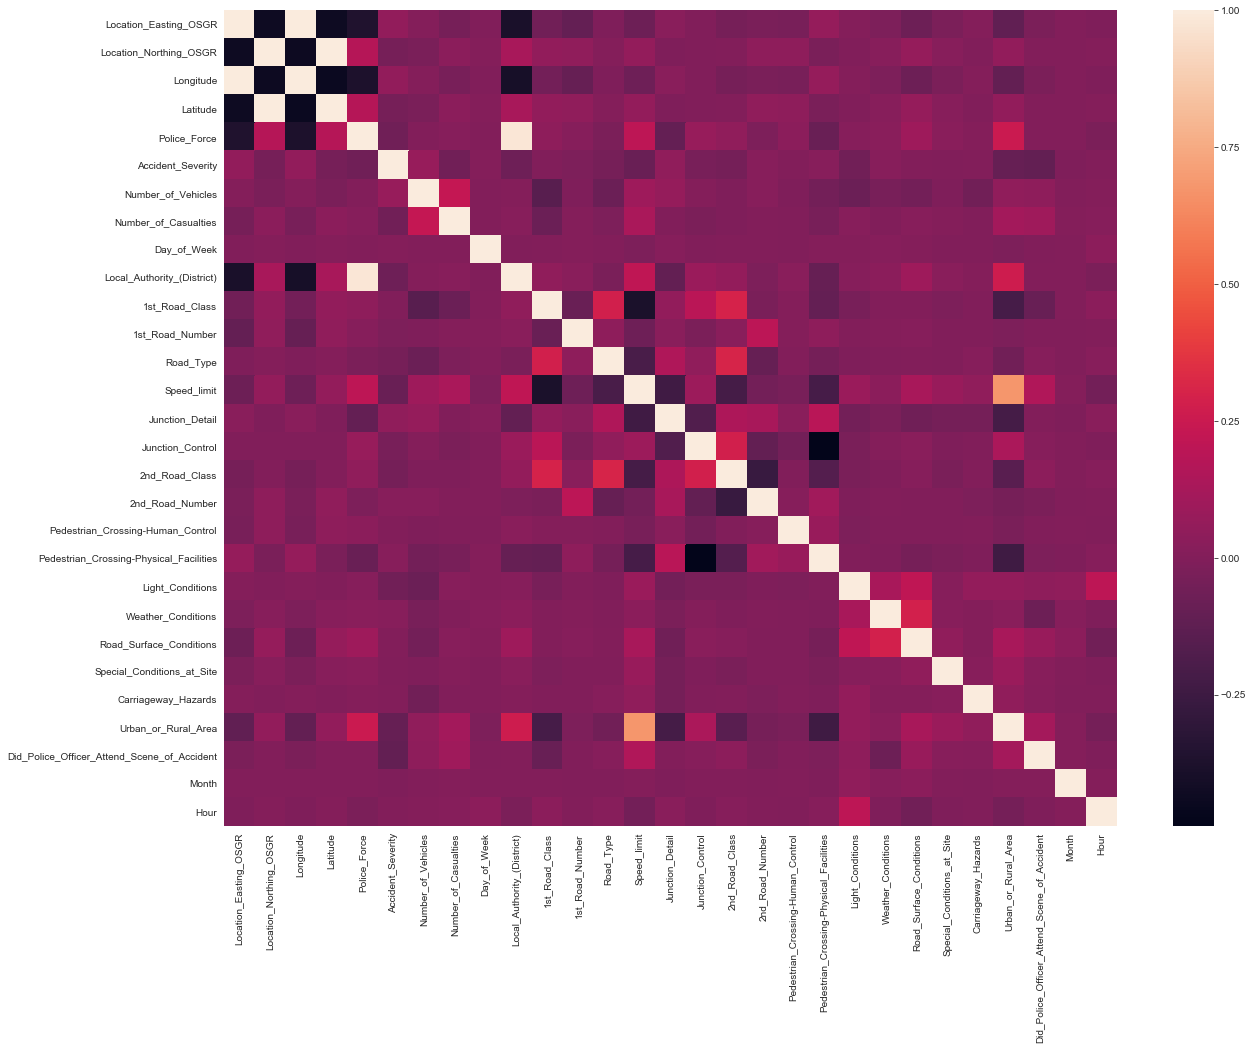

In [41]:
plt.figure(2, figsize=(20,15))
sns.heatmap(df_acc.corr())

### Feature Engineering

#### Time 

In [42]:
df_acc['Time_int'] = pd.to_datetime(df_acc.Time).astype(int)/10**9

In [43]:
df_acc['Date_int'] = pd.to_datetime(df_acc.Date).astype(int)/10**9

#### Building the rush hour

In [44]:
def rush_hour(hour):
    if hour >= 6 and hour < 9:
        return "6-9"
    elif hour >= 9 and hour < 16:
        return "9-16"
    elif hour >= 16 and hour < 19:
        return "16-19"
    elif hour >= 19 and hour < 22:
        return "19-22"
    else:
        return "22-6"
df_acc['Rush Hour'] = df_acc['Hour'].apply(rush_hour)
df_acc[['Time', 'Hour', 'Rush Hour']].head(8)

,Time,Hour,Rush Hour
0,13:21,13,9-16
1,23:00,23,22-6
2,10:40,10,9-16
3,17:45,17,16-19
4,08:50,8,6-9
5,14:11,14,9-16
6,18:25,18,16-19
7,17:50,17,16-19


#### Holidays and Shifted Holidays 

In [45]:
uk_holidays = holidays.UK()
uk_holidays['2014-01-01': '2014-12-31']

[datetime.date(2014, 1, 1),
 datetime.date(2014, 1, 2),
 datetime.date(2014, 3, 17),
 datetime.date(2014, 4, 18),
 datetime.date(2014, 4, 21),
 datetime.date(2014, 5, 5),
 datetime.date(2014, 5, 26),
 datetime.date(2014, 7, 12),
 datetime.date(2014, 8, 4),
 datetime.date(2014, 8, 25),
 datetime.date(2014, 11, 30),
 datetime.date(2014, 12, 25),
 datetime.date(2014, 12, 26)]

In [46]:
# creating holidays
df_acc['Holiday'] = [ i in uk_holidays for i in df_acc.Date]
#shifting the holidays
df_acc['Holiday-1'] = [ i in uk_holidays for i in df_acc.dt -pd.Timedelta(days=1)]
df_acc['Holiday-2'] = [ i in uk_holidays for i in df_acc.dt -pd.Timedelta(days=2)]
df_acc['Holiday+1'] = [ i in uk_holidays for i in df_acc.dt +pd.Timedelta(days=1)]
df_acc['Holiday+2'] = [ i in uk_holidays for i in df_acc.dt +pd.Timedelta(days=2)]

In [95]:
#check
df_acc.loc[df_acc.Date=='26/12/2014',['Date','Holiday','Holiday-1','Holiday-2',
                                      'Holiday+1','Holiday+2']].head()

,Date,Holiday,Holiday-1,Holiday-2,Holiday+1,Holiday+2
702,26/12/2014,True,True,False,False,False
1067,26/12/2014,True,True,False,False,False
2651,26/12/2014,True,True,False,False,False
2653,26/12/2014,True,True,False,False,False
2655,26/12/2014,True,True,False,False,False


#### Rounding the time to nearest half 15min

In [104]:
df_acc['Time_rounded'] = df_acc.dt.dt.round('15min').dt.strftime('%H:%M')
df_acc[['dt','Time','Time_rounded','Time_int']].head()

,dt,Time,Time_rounded,Time_int
0,2014-09-01 13:21:00,13:21,13:15,1.578835e+09
1,2014-01-20 23:00:00,23:00,23:00,1.578870e+09
2,2014-01-21 10:40:00,10:40,10:45,1.578826e+09
3,2014-01-15 17:45:00,17:45,17:45,1.578851e+09
4,2014-09-01 08:50:00,08:50,08:45,1.578819e+09


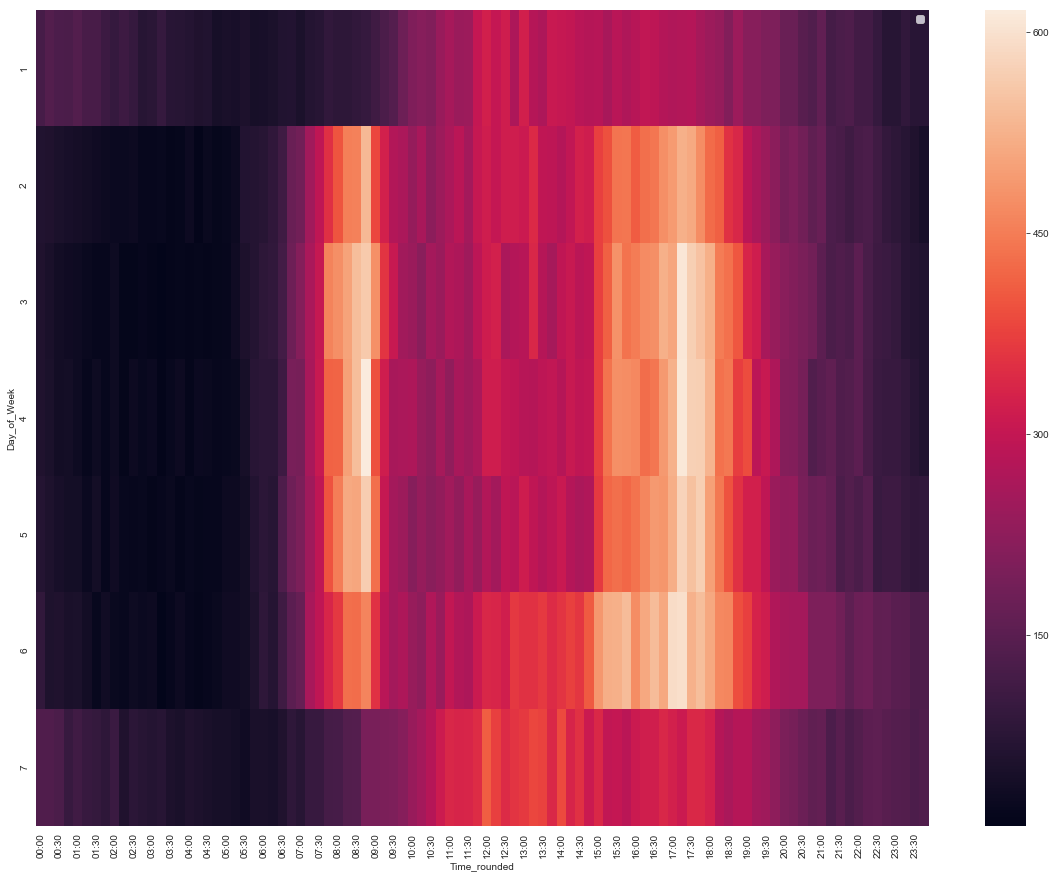

In [106]:
df_wt=df_acc.groupby(['Day_of_Week','Time_rounded']).size().unstack()
plt.figure(2, figsize=(20,15))
sns.heatmap(data=df_wt)
plt.legend('Heatmap of the count of accidents')

## Machine Learning 

In [50]:
df_acc.columns
# df_acc.isna().sum()

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'dt', 'Month', 'Hour', 'Time_int', 'Date_int', 'Rush Hour', 'Holiday', 'Holiday-1', 'Holiday-2', 'Holiday+1', 'Holiday+2', 'Time_rounded'], dtype='object')

In [51]:
columns = [
 'Date', 
 'dt',
 'Location_Easting_OSGR', 
 'Location_Northing_OSGR', 
 'Longitude',
 'Latitude', 
 'Number_of_Vehicles', 
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Time',
 'Speed_limit', 
 'Day_of_Week',
 'Month', 
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force', 
 'Accident_Severity', 
 'Local_Authority_(District)', 
 'Local_Authority_(Highway)', 
 '1st_Road_Class', 
 '1st_Road_Number', 
 'Road_Type', 
 'Junction_Detail', 
 'Junction_Control', 
 '2nd_Road_Class',
 '2nd_Road_Number', 
 'Pedestrian_Crossing-Human_Control', 
 'Pedestrian_Crossing-Physical_Facilities', 
 'Light_Conditions', 
 'Weather_Conditions', 
 'Road_Surface_Conditions', 
 'Special_Conditions_at_Site', 
 'Carriageway_Hazards', 
 'Urban_or_Rural_Area', 
 'LSOA_of_Accident_Location', 
 'Did_Police_Officer_Attend_Scene_of_Accident'
]
len(columns)

43

In [52]:
#column types
column_types = ['time']*2 + \
               ['real']*8 + \
               ['enum' for _ in range(len(columns) - 10)] 
len(column_types)
for o in (zip(columns,column_types)):
    print(o)


('Date', 'time')
('dt', 'time')
('Location_Easting_OSGR', 'real')
('Location_Northing_OSGR', 'real')
('Longitude', 'real')
('Latitude', 'real')
('Number_of_Vehicles', 'real')
('Number_of_Casualties', 'real')
('Time_int', 'real')
('Date_int', 'real')
('Time', 'enum')
('Speed_limit', 'enum')
('Day_of_Week', 'enum')
('Month', 'enum')
('Hour', 'enum')
('Rush Hour', 'enum')
('Holiday', 'enum')
('Holiday-1', 'enum')
('Holiday-2', 'enum')
('Holiday+1', 'enum')
('Holiday+2', 'enum')
('Time_rounded', 'enum')
('Police_Force', 'enum')
('Accident_Severity', 'enum')
('Local_Authority_(District)', 'enum')
('Local_Authority_(Highway)', 'enum')
('1st_Road_Class', 'enum')
('1st_Road_Number', 'enum')
('Road_Type', 'enum')
('Junction_Detail', 'enum')
('Junction_Control', 'enum')
('2nd_Road_Class', 'enum')
('2nd_Road_Number', 'enum')
('Pedestrian_Crossing-Human_Control', 'enum')
('Pedestrian_Crossing-Physical_Facilities', 'enum')
('Light_Conditions', 'enum')
('Weather_Conditions', 'enum')
('Road_Surface_C

In [53]:
df=df_acc.sample(frac=1).reset_index(drop=True)[columns].copy()
train_df = df[:int(len(df)*0.8)]
test_df  = df[int(len(df)*0.8):]


#check the imbalance in test set
print (test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
        format(round((test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                      len(test_df))
                                                     *100)))

23948 5317
Police attended in the 18.0% of cases


In [54]:
#check the imbalance in train set
print (train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
        format(round((train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                      len(train_df))
                                                     *100)))

95659 21398
Police attended in the 18.0% of cases


In [55]:
# h2o.cluster().shutdown()
# h2o.remove_all()

In [56]:
## Import data into h2o
h2o.init(ip='localhost', port=54321) #nthreads=70, 
# h2o.connect(ip='192.168.0.31',  port=54321)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/norayr/opt/anaconda3/envs/dev/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/g0/9mcysmmd1qx8jnd4lsx2j55h0000gp/T/tmpuo5d31hu
  JVM stdout: /var/folders/g0/9mcysmmd1qx8jnd4lsx2j55h0000gp/T/tmpuo5d31hu/h2o_norayr_started_from_python.out
  JVM stderr: /var/folders/g0/9mcysmmd1qx8jnd4lsx2j55h0000gp/T/tmpuo5d31hu/h2o_norayr_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,26 days
H2O cluster name:,H2O_from_python_norayr_uq00qh
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [57]:
## import data to h2o
train_d = h2o.H2OFrame(train_df, column_types=column_types, destination_frame='train')
train,val = train_d.split_frame(ratios=[0.8])
# val = h2o.H2OFrame(val_pd,  column_types=column_types)
test = h2o.H2OFrame(test_df, column_types=column_types, destination_frame='test')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [58]:
train.shape

(93543, 43)

## XGBoost

In [59]:
## set predictors and response
predictors = train.columns[:-1]

remove = [
#         'Date', 
#         'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
#         'Local_Authority_(District)', 
#         'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
        'Time',
#         'Time_rounded',
        'Time_int',
#         'Police_Force',
#          'Weather_Conditions',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'dt',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Date_int',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force',
 'Accident_Severity',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  538.6885719299316
xgboost prediction progress: |████████████████████████████████████████████| 100%


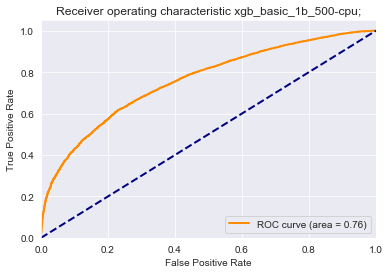

In [60]:

################################################################################################
## xgboost on cpu
model_xgb = H2OXGBoostEstimator(
#     balance_classes = True,
#     categorical_encoding='one_hot_explicit',
    model_id="xgb_basic_1b_500-cpu",
    ntrees=500
    ,max_depth=15
    ,tree_method='exact'
    # ,max_abs_leafnode_pred = 0.5
    # ,nfolds=5
    # ,fold_assignment='Modulo'
    ,score_tree_interval=5
    ,min_rows = 50
    ,distribution='bernoulli'
    ,sample_rate=1
    ,col_sample_rate=1
    ,col_sample_rate_per_tree=1
    ,learn_rate=0.02
    ,stopping_rounds=10
    ,stopping_tolerance=0.0001
    ,stopping_metric="AUC" #"misclassification" #"logloss" #"misclassification" # "AUCPR"  #   "AUC" #
    ,score_each_iteration=False
    # ,keep_cross_validation_predictions=True
    ,seed=4413976168041433600
    ,backend='cpu'
)

t_start=time.time()
model_xgb.train(x=predictors, y=response, training_frame=train_d ) #training_frame=train, validation_frame=val)
# model_xgb.train(x=predictors, y=response, training_frame=train, validation_frame=val)

tt=time.time()-t_start
print("Time to train (sec): ", tt)

prediction_BOOL_xgb=draw_roc(test,model_xgb,False)

In [61]:
print( model_xgb.model_performance(test))


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.12894606881604329
RMSE: 0.35909061365627937
LogLoss: 0.4065214705111339
Mean Per-Class Error: 0.30680919561187037
AUC: 0.7585643643793576
AUCPR: 0.9306159301995528
Gini: 0.5171287287587152

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4950263227025668: 


,,0,1,Error,Rate
0,0,398.0,4919.0,0.9251,(4919.0/5317.0)
1,1,209.0,23739.0,0.0087,(209.0/23948.0)
2,Total,607.0,28658.0,0.1752,(5128.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.495026,0.902521,331.0
1,max f2,0.204398,0.957599,383.0
2,max f0point5,0.706638,0.868760,227.0
3,max accuracy,0.495026,0.824774,331.0
4,max precision,0.993763,1.000000,0.0
5,max recall,0.087066,1.000000,398.0
6,max specificity,0.993763,1.000000,0.0
7,max absolute_mcc,0.810818,0.299819,155.0
8,max min_per_class_accuracy,0.801391,0.686738,161.0
9,max mean_per_class_accuracy,0.829657,0.693191,140.0



Gains/Lift Table: Avg response rate: 81.83 %, avg score: 81.87 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.990518,1.222023,1.222023,1.000000,0.991893,1.000000,0.991893,0.012235,0.012235,22.202272,22.202272
1,,2,0.020024,0.988744,1.217852,1.219937,0.996587,0.989625,0.998294,0.990759,0.012193,0.024428,21.785199,21.993735
2,,3,0.030002,0.986818,1.201098,1.213672,0.982877,0.987813,0.993166,0.989779,0.011984,0.036412,20.109767,21.367176
3,,4,0.040014,0.984350,1.209511,1.212631,0.989761,0.985582,0.992314,0.988729,0.012110,0.048522,20.951054,21.263057
4,,5,0.050026,0.981792,1.209511,1.212006,0.989761,0.983011,0.991803,0.987585,0.012110,0.060631,20.951054,21.200614
5,,6,0.100017,0.970018,1.202811,1.207410,0.984279,0.975802,0.988042,0.981695,0.060130,0.120762,20.281115,20.741021
6,,7,0.150009,0.957321,1.190282,1.201702,0.974026,0.963941,0.983371,0.975778,0.059504,0.180266,19.028187,20.170206
7,,8,0.200000,0.944150,1.166894,1.193002,0.954887,0.950828,0.976251,0.969542,0.058335,0.238600,16.689387,19.300150
8,,9,0.300017,0.912628,1.139775,1.175257,0.932696,0.928891,0.961731,0.955990,0.113997,0.352597,13.977520,17.525738
9,,10,0.400000,0.880074,1.096730,1.155629,0.897471,0.896161,0.945669,0.941035,0.109654,0.462252,9.672989,15.562886


xgboost prediction progress: |████████████████████████████████████████████| 100%


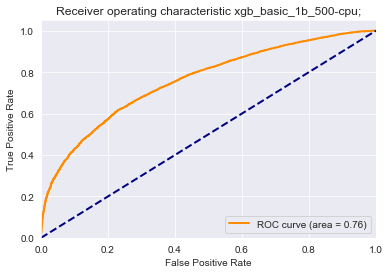

xgboost prediction progress: |████████████████████████████████████████████| 100%


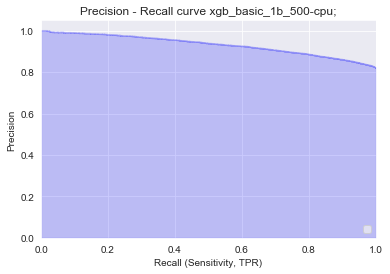

xgboost prediction progress: |████████████████████████████████████████████| 100%


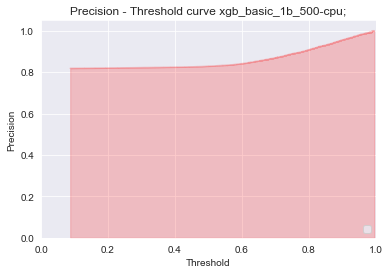

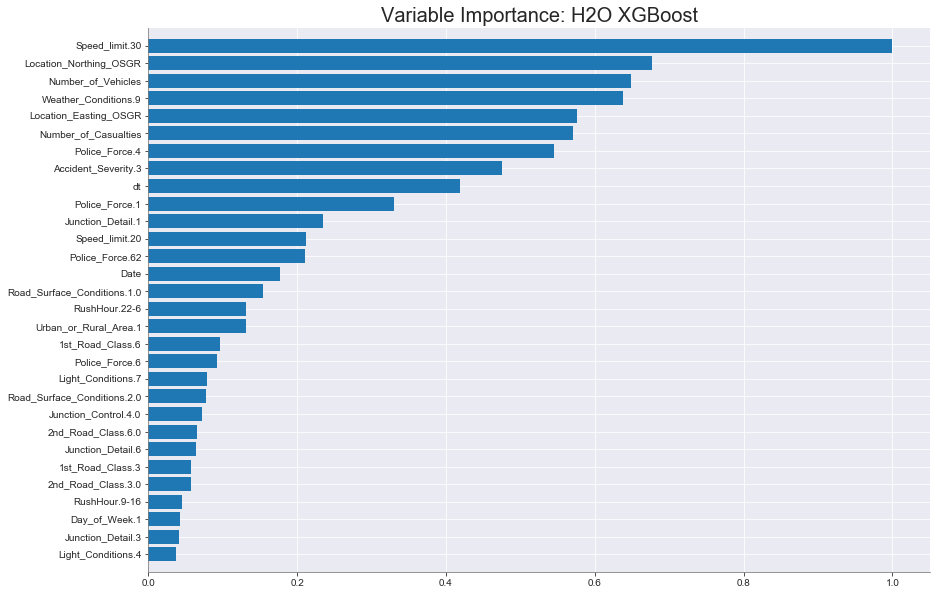

In [62]:
pred_xgb=draw_roc(test,model_xgb,False)
pr=draw_prec_recall(test,model_xgb,False)
pt=draw_prec_thr(test,model_xgb,False)


# Drav variable importances from h2o
model_xgb.varimp_plot(30)

In [63]:
# Print variable importance list
[[i[0],round(i[2],1)] for i in model_xgb.varimp()]

[['Speed_limit.30', 1.0],
 ['Location_Northing_OSGR', 0.7],
 ['Number_of_Vehicles', 0.6],
 ['Weather_Conditions.9', 0.6],
 ['Location_Easting_OSGR', 0.6],
 ['Number_of_Casualties', 0.6],
 ['Police_Force.4', 0.5],
 ['Accident_Severity.3', 0.5],
 ['dt', 0.4],
 ['Police_Force.1', 0.3],
 ['Junction_Detail.1', 0.2],
 ['Speed_limit.20', 0.2],
 ['Police_Force.62', 0.2],
 ['Date', 0.2],
 ['Road_Surface_Conditions.1.0', 0.2],
 ['RushHour.22-6', 0.1],
 ['Urban_or_Rural_Area.1', 0.1],
 ['1st_Road_Class.6', 0.1],
 ['Police_Force.6', 0.1],
 ['Light_Conditions.7', 0.1],
 ['Road_Surface_Conditions.2.0', 0.1],
 ['Junction_Control.4.0', 0.1],
 ['2nd_Road_Class.6.0', 0.1],
 ['Junction_Detail.6', 0.1],
 ['1st_Road_Class.3', 0.1],
 ['2nd_Road_Class.3.0', 0.1],
 ['RushHour.9-16', 0.0],
 ['Day_of_Week.1', 0.0],
 ['Junction_Detail.3', 0.0],
 ['Light_Conditions.4', 0.0],
 ['Speed_limit.40', 0.0],
 ['Accident_Severity.1', 0.0],
 ['RushHour.16-19', 0.0],
 ['Road_Type.6', 0.0],
 ['RushHour.19-22', 0.0],
 ['RushH

In [64]:
################################################################################################
# real_v= pred_df.if_failed
real_v = test['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values
pred_xgb = model_xgb.predict(test)
p_yes_xgb = pred_xgb.as_data_frame()['p1']

# pred_gbm=draw_roc(test,model_gbm,False)

for t in range(100,800,5):
    print_stats(t/1000,real_v, p_yes_xgb)
    print(' \n ')

xgboost prediction progress: |████████████████████████████████████████████| 100%
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.923
F1 =  0.9
MCC =  0.0405
Threshold =  0.1
[[   12  5305]
 [    1 23947]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.003
NPV =  0.933
F1 =  0.9
MCC =  0.0441
Threshold =  0.105
[[   14  5303]
 [    1 23947]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.003
NPV =  0.85
F1 =  0.9
MCC =  0.0453
Threshold =  0.11
[[   17  5300]
 [    3 23945]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.003
NPV =  0.857
F1 =  0.9
MCC =  0.0469
Threshold =  0.115
[[   18  5299]
 [    3 23945]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.004
NPV =  0.792
F1 =  0.9
MCC =  0.0453
Threshold =  0.12
[[   19  5298]
 [    5 23943]]
 
 
Accuracy =  81.8999

MCC =  0.1288
Threshold =  0.33
[[  165  5152]
 [   54 23894]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.823
Sensitivity =  0.998
Specificity =  0.031
NPV =  0.742
F1 =  0.9
MCC =  0.128
Threshold =  0.335
[[  167  5150]
 [   58 23890]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.823
Sensitivity =  0.997
Specificity =  0.033
NPV =  0.739
F1 =  0.9
MCC =  0.1298
Threshold =  0.34
[[  173  5144]
 [   61 23887]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.823
Sensitivity =  0.997
Specificity =  0.033
NPV =  0.743
F1 =  0.9
MCC =  0.1314
Threshold =  0.345
[[  176  5141]
 [   61 23887]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.823
Sensitivity =  0.997
Specificity =  0.033
NPV =  0.742
F1 =  0.9
MCC =  0.1321
Threshold =  0.35
[[  178  5139]
 [   62 23886]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.823
Sensitivity =  0.997
Specificity =  0.034
NPV =  0.734
F1 =  0.9
MCC =  0.1324
Threshold =  0.355
[[  182  5135]
 [   66 23882]]
 
 
Accuracy =  82.3
Prec

F1 =  0.9
MCC =  0.2001
Threshold =  0.56
[[  683  4634]
 [  565 23383]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.835
Sensitivity =  0.975
Specificity =  0.134
NPV =  0.543
F1 =  0.9
MCC =  0.2034
Threshold =  0.565
[[  714  4603]
 [  600 23348]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.836
Sensitivity =  0.973
Specificity =  0.138
NPV =  0.537
F1 =  0.9
MCC =  0.2042
Threshold =  0.57
[[  736  4581]
 [  635 23313]]
 
 
Accuracy =  82.1
Precsision =  0.836
Sensitivity =  0.971
Specificity =  0.145
NPV =  0.526
F1 =  0.9
MCC =  0.2049
Threshold =  0.575
[[  769  4548]
 [  692 23256]]
 
 
Accuracy =  82.1
Precsision =  0.838
Sensitivity =  0.969
Specificity =  0.153
NPV =  0.527
F1 =  0.9
MCC =  0.2115
Threshold =  0.58
[[  815  4502]
 [  732 23216]]
 
 
Accuracy =  82.0
Precsision =  0.838
Sensitivity =  0.967
Specificity =  0.161
NPV =  0.518
F1 =  0.9
MCC =  0.2137
Threshold =  0.585
[[  857  4460]
 [  796 23152]]
 
 
Accuracy =  82.0
Precsision =  0.839
Sensitivity 

F1 =  0.79
MCC =  0.2989
Threshold =  0.795
[[ 3581  1736]
 [ 7178 16770]]
 
 


In [65]:
print_stats(0.775,real_v, p_yes_xgb)

Accuracy =  71.89999999999999
Precsision =  0.897
Sensitivity =  0.742
Specificity =  0.618
NPV =  0.347
F1 =  0.81
MCC =  0.2961
Threshold =  0.795
[[ 3284  2033]
 [ 6188 17760]]


MCC is arround 0.3 due to class imbalance

## GBM 

In [66]:
## set predictors and response
predictors = train.columns[:-1]

# list of features to be removed
remove = [
#         'Date', 
#         'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
        'Local_Authority_(District)', 
        'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
        'Time',
#         'Time_rounded',
#         'Time_int',
#         'Police_Force',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'dt',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force',
 'Accident_Severity',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

In [67]:
#######################################################################################
## GBM
# # Create and train GBM
model_gbm = H2OGradientBoostingEstimator(
    model_id="gbm_basic"
    ,balance_classes = True
    ,ntrees= 200 # 74
    ,max_depth=7
#     ,nfolds=5
    # ,fold_assignment='Sparse'
    ,score_tree_interval=10
    ,min_rows = 100
    ,distribution='bernoulli'
    ,sample_rate=0.8
    ,col_sample_rate=0.8
    ,col_sample_rate_per_tree=0.8
    ,learn_rate=0.08
    # ,stopping_tolerance=0.01 #10-fold increase in threshold as defined in rf_v1
    # ,stopping_rounds=0
    , stopping_metric="AUC"  #"misclassification" # "AUCPR" # "logloss" # 
    ,score_each_iteration=False
    # ,keep_cross_validation_predictions=True
    ,seed=4413976168041433600
)
t_start=time.time()
model_gbm.train(x=predictors, y=response, training_frame=train_d )#, validation_frame=val)
# model_gbm.train(x=predictors, y=response, training_frame=train, validation_frame=val)

tt=time.time()-t_start
print("Time to train (sec): ", tt)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  25.136316061019897


In [68]:
print( model_gbm.model_performance(test))


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13057971123910558
RMSE: 0.3613581481565146
LogLoss: 0.4131365989788317
Mean Per-Class Error: 0.3186347989448268
AUC: 0.7516585995881805
AUCPR: 0.9232888765158387
Gini: 0.503317199176361

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4331633971264897: 


,,0,1,Error,Rate
0,0,246.0,5071.0,0.9537,(5071.0/5317.0)
1,1,110.0,23838.0,0.0046,(110.0/23948.0)
2,Total,356.0,28909.0,0.177,(5181.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.433163,0.901981,348.0
1,max f2,0.171940,0.957670,389.0
2,max f0point5,0.717911,0.868030,231.0
3,max accuracy,0.546756,0.823373,315.0
4,max precision,0.996782,0.996610,3.0
5,max recall,0.115426,1.000000,395.0
6,max specificity,0.998826,0.999812,0.0
7,max absolute_mcc,0.805416,0.286792,172.0
8,max min_per_class_accuracy,0.831363,0.678929,153.0
9,max mean_per_class_accuracy,0.841139,0.681365,146.0



Gains/Lift Table: Avg response rate: 81.83 %, avg score: 84.12 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.998051,1.213681,1.213681,0.993174,0.998599,0.993174,0.998599,0.012151,0.012151,21.368126,21.368126
1,,2,0.020024,0.997323,1.217852,1.215767,0.996587,0.997681,0.994881,0.998140,0.012193,0.024344,21.785199,21.576663
2,,3,0.030002,0.996437,1.222023,1.217847,1.000000,0.996891,0.996583,0.997725,0.012193,0.036537,22.202272,21.784724
3,,4,0.040014,0.995356,1.213681,1.216805,0.993174,0.995928,0.995730,0.997275,0.012151,0.048689,21.368126,21.680486
4,,5,0.050026,0.993915,1.213681,1.216180,0.993174,0.994653,0.995219,0.996750,0.012151,0.060840,21.368126,21.617971
5,,6,0.100017,0.985525,1.191952,1.204070,0.975393,0.989702,0.985309,0.993227,0.059587,0.120428,19.195244,20.407021
6,,7,0.150009,0.975884,1.181929,1.196691,0.967191,0.980806,0.979271,0.989088,0.059086,0.179514,18.192901,19.669149
7,,8,0.200000,0.965202,1.170235,1.190079,0.957621,0.970774,0.973860,0.984510,0.058502,0.238016,17.023501,19.007850
8,,9,0.300017,0.939476,1.141863,1.174005,0.934404,0.952939,0.960706,0.973985,0.114206,0.352221,14.186270,17.400474
9,,10,0.400000,0.908772,1.094642,1.154167,0.895762,0.924343,0.944473,0.961577,0.109445,0.461667,9.464167,15.416736


gbm prediction progress: |████████████████████████████████████████████████| 100%


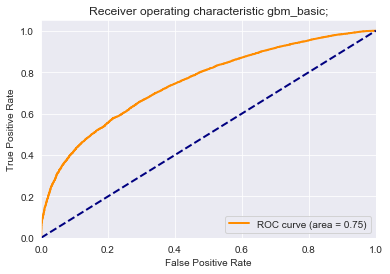

gbm prediction progress: |████████████████████████████████████████████████| 100%


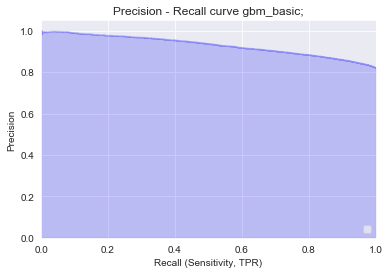

gbm prediction progress: |████████████████████████████████████████████████| 100%


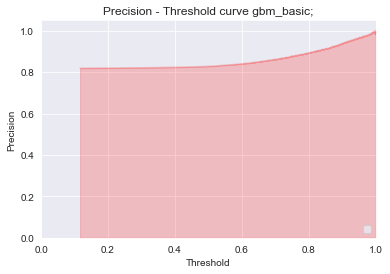

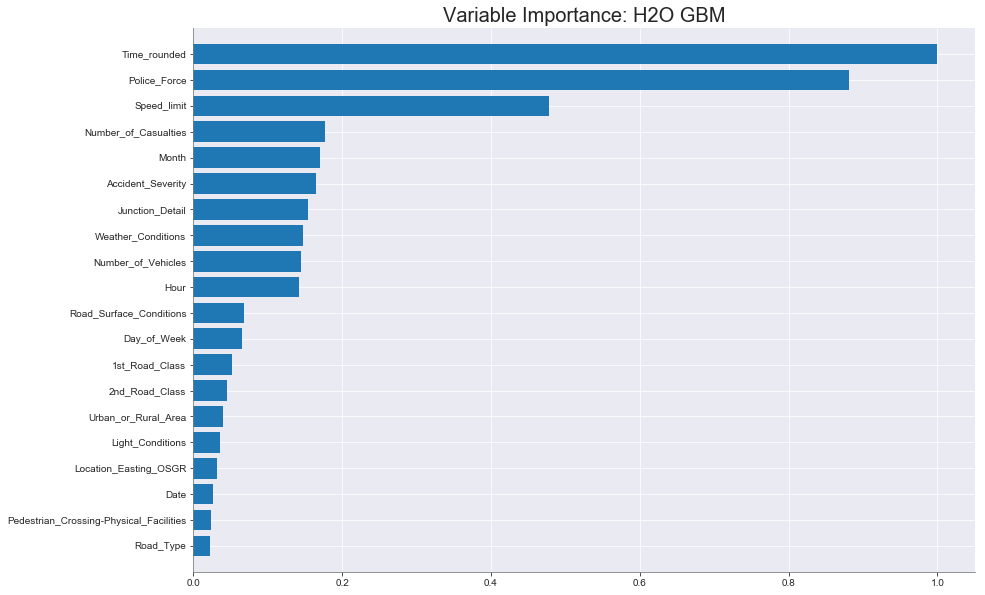

In [69]:
pred_gbm=draw_roc(test,model_gbm,False)

pr=draw_prec_recall(test,model_gbm,False)
pt=draw_prec_thr(test,model_gbm,False)


# Drav variable importances from h2o
model_gbm.varimp_plot(20)

In [70]:
# Print variable importance list
[[i[0],round(i[2],2)] for i in model_gbm.varimp()]

[['Time_rounded', 1.0],
 ['Police_Force', 0.88],
 ['Speed_limit', 0.48],
 ['Number_of_Casualties', 0.18],
 ['Month', 0.17],
 ['Accident_Severity', 0.17],
 ['Junction_Detail', 0.15],
 ['Weather_Conditions', 0.15],
 ['Number_of_Vehicles', 0.15],
 ['Hour', 0.14],
 ['Road_Surface_Conditions', 0.07],
 ['Day_of_Week', 0.06],
 ['1st_Road_Class', 0.05],
 ['2nd_Road_Class', 0.04],
 ['Urban_or_Rural_Area', 0.04],
 ['Light_Conditions', 0.04],
 ['Location_Easting_OSGR', 0.03],
 ['Date', 0.03],
 ['Pedestrian_Crossing-Physical_Facilities', 0.02],
 ['Road_Type', 0.02],
 ['Time_int', 0.02],
 ['Location_Northing_OSGR', 0.02],
 ['Junction_Control', 0.02],
 ['Date_int', 0.01],
 ['dt', 0.01],
 ['Special_Conditions_at_Site', 0.01],
 ['Carriageway_Hazards', 0.0],
 ['Rush Hour', 0.0],
 ['Holiday+2', 0.0],
 ['Holiday-1', 0.0],
 ['Holiday+1', 0.0],
 ['Holiday', 0.0],
 ['Holiday-2', 0.0],
 ['Pedestrian_Crossing-Human_Control', 0.0]]

In [71]:
################################################################################################
# real_v= pred_df.if_failed
real_v = test['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values
pred_gbm = model_gbm.predict(test)
p_yes_gbm = pred_gbm.as_data_frame()['p1']

# pred_gbm=draw_roc(test,model_gbm,False)

for t in range(100,800,5):
    print_stats(t/1000,real_v, p_yes_gbm)
    print(' \n ')

gbm prediction progress: |████████████████████████████████████████████████| 100%
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.002
NPV =  1.0
F1 =  0.9
MCC =  0.0392
Threshold =  0.1
[[   10  5307]
 [    0 23948]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.002
NPV =  1.0
F1 =  0.9
MCC =  0.043
Threshold =  0.105
[[   12  5305]
 [    0 23948]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.002
NPV =  1.0
F1 =  0.9
MCC =  0.0447
Threshold =  0.11
[[   13  5304]
 [    0 23948]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.003
NPV =  1.0
F1 =  0.9
MCC =  0.0464
Threshold =  0.115
[[   14  5303]
 [    0 23948]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.819
Sensitivity =  1.0
Specificity =  0.003
NPV =  0.941
F1 =  0.9
MCC =  0.0475
Threshold =  0.12
[[   16  5301]
 [    1 23947]]
 
 
Accuracy =  81.899999999999

 
Accuracy =  82.19999999999999
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.026
NPV =  0.777
F1 =  0.9
MCC =  0.121
Threshold =  0.335
[[  139  5178]
 [   40 23908]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.027
NPV =  0.777
F1 =  0.9
MCC =  0.1228
Threshold =  0.34
[[  143  5174]
 [   41 23907]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.029
NPV =  0.777
F1 =  0.9
MCC =  0.127
Threshold =  0.345
[[  153  5164]
 [   44 23904]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.029
NPV =  0.768
F1 =  0.9
MCC =  0.1272
Threshold =  0.35
[[  156  5161]
 [   47 23901]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.823
Sensitivity =  0.998
Specificity =  0.03
NPV =  0.773
F1 =  0.9
MCC =  0.1294
Threshold =  0.355
[[  160  5157]
 [   47 23901]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.823
Sensitivity =  0.998
Specificity =  0.

Sensitivity =  0.973
Specificity =  0.14
NPV =  0.539
F1 =  0.9
MCC =  0.2062
Threshold =  0.57
[[  745  4572]
 [  638 23310]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.837
Sensitivity =  0.972
Specificity =  0.144
NPV =  0.534
F1 =  0.9
MCC =  0.2078
Threshold =  0.575
[[  768  4549]
 [  670 23278]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.838
Sensitivity =  0.97
Specificity =  0.152
NPV =  0.531
F1 =  0.9
MCC =  0.2124
Threshold =  0.58
[[  809  4508]
 [  714 23234]]
 
 
Accuracy =  82.1
Precsision =  0.838
Sensitivity =  0.968
Specificity =  0.157
NPV =  0.524
F1 =  0.9
MCC =  0.2128
Threshold =  0.585
[[  835  4482]
 [  760 23188]]
 
 
Accuracy =  82.0
Precsision =  0.839
Sensitivity =  0.966
Specificity =  0.163
NPV =  0.518
F1 =  0.9
MCC =  0.2144
Threshold =  0.59
[[  865  4452]
 [  806 23142]]
 
 
Accuracy =  82.0
Precsision =  0.84
Sensitivity =  0.964
Specificity =  0.17
NPV =  0.514
F1 =  0.9
MCC =  0.2181
Threshold =  0.595
[[  905  4412]
 [  855 23093]]
 


In [72]:
print_stats(0.816032,real_v, p_yes_gbm)

Accuracy =  69.89999999999999
Precsision =  0.899
Sensitivity =  0.712
Specificity =  0.641
NPV =  0.331
F1 =  0.79
MCC =  0.285
Threshold =  0.795
[[ 3408  1909]
 [ 6895 17053]]


Confusion matrix, without normalization
[[  317  5000]
 [  183 23765]]


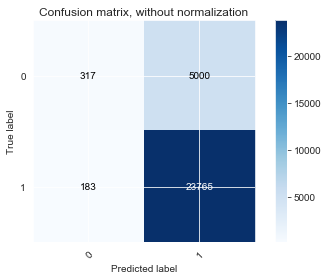

In [73]:
plot_confusion_matrix(0.4688,real_v,  pred_gbm.as_data_frame()['p1'], [0,1])
# pred_gbm

In [74]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(real_v, pred_gbm.as_data_frame()['predict'], digits=3))

              precision    recall  f1-score   support

           0      0.359     0.540     0.432      5317
           1      0.885     0.786     0.833     23948

    accuracy                          0.742     29265
   macro avg      0.622     0.663     0.632     29265
weighted avg      0.790     0.742     0.760     29265



## GLM

In [75]:
## set predictors and response
predictors = train.columns[:-1]

remove = [
#         'Date', 
#         'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
#         'Local_Authority_(District)', 
#         'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
#         'Time',
#         'Time_rounded',
#         'Time_int',
#         'Police_Force',
#          'Weather_Conditions',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'dt',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Time',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force',
 'Accident_Severity',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

glm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  3.9677889347076416
glm prediction progress: |████████████████████████████████████████████████| 100%


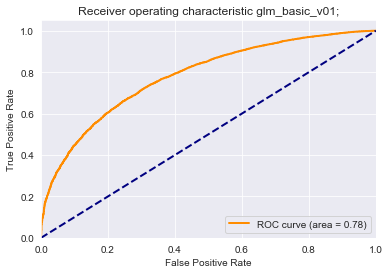

In [76]:

## Starting GLM

model_glm = H2OGeneralizedLinearEstimator(
    # balance_classes = True,
    # categorical_encoding='one_hot_explicit',
    max_iterations= 1000,
    early_stopping = False,
    objective_epsilon= 0.000001,
    alpha=0.3,
    lambda_ = 1e-4,
    model_id="glm_basic_v01",
    family='binomial'
)
t_start=time.time()
model_glm.train(x=predictors, y=response, training_frame=train_d) #, validation_frame=val)
tt=time.time()-t_start
print("Time to train (sec): ", tt)

prediction_glm=draw_roc(test,model_glm,False)


In [77]:
print( model_glm.model_performance(test))


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.12401634218765716
RMSE: 0.3521595408158881
LogLoss: 0.39397806977334343
Null degrees of freedom: 29264
Residual degrees of freedom: 28537
Null deviance: 27739.855370093097
Residual deviance: 23059.536423833786
AIC: 24515.536423833786
AUC: 0.7814625877854152
AUCPR: 0.933065543965671
Gini: 0.5629251755708304

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47192774259985637: 


,,0,1,Error,Rate
0,0,552.0,4765.0,0.8962,(4765.0/5317.0)
1,1,274.0,23674.0,0.0114,(274.0/23948.0)
2,Total,826.0,28439.0,0.1722,(5039.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.471928,0.903812,330.0
1,max f2,0.174737,0.957680,387.0
2,max f0point5,0.706069,0.879691,226.0
3,max accuracy,0.565533,0.830002,297.0
4,max precision,0.996031,0.997996,3.0
5,max recall,0.095693,1.000000,396.0
6,max specificity,0.999301,0.999812,0.0
7,max absolute_mcc,0.734654,0.341159,209.0
8,max min_per_class_accuracy,0.805136,0.705849,163.0
9,max mean_per_class_accuracy,0.820862,0.707157,152.0



Gains/Lift Table: Avg response rate: 81.83 %, avg score: 81.76 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.997453,1.217852,1.217852,0.996587,0.998601,0.996587,0.998601,0.012193,0.012193,21.785199,21.785199
1,,2,0.020024,0.994620,1.217852,1.217852,0.996587,0.996028,0.996587,0.997314,0.012193,0.024386,21.785199,21.785199
2,,3,0.030002,0.991277,1.217838,1.217847,0.996575,0.993082,0.996583,0.995907,0.012151,0.036537,21.783771,21.784724
3,,4,0.040014,0.987387,1.209511,1.215761,0.989761,0.989399,0.994876,0.994279,0.012110,0.048647,20.951054,21.576128
4,,5,0.050026,0.983932,1.217852,1.216180,0.996587,0.985709,0.995219,0.992563,0.012193,0.060840,21.785199,21.617971
5,,6,0.100017,0.967655,1.193623,1.204905,0.976760,0.975252,0.985992,0.983910,0.059671,0.120511,19.362301,20.490521
6,,7,0.150009,0.953570,1.194458,1.201424,0.977444,0.960246,0.983144,0.976024,0.059713,0.180224,19.445829,20.142370
7,,8,0.200000,0.940548,1.166894,1.192793,0.954887,0.947095,0.976081,0.968793,0.058335,0.238559,16.689387,19.279272
8,,9,0.300017,0.913397,1.146038,1.177206,0.937820,0.927010,0.963326,0.954864,0.114623,0.353182,14.603770,17.720594
9,,10,0.400000,0.886492,1.113018,1.161162,0.910800,0.900205,0.950196,0.941201,0.111283,0.464465,11.301796,16.116168


glm prediction progress: |████████████████████████████████████████████████| 100%


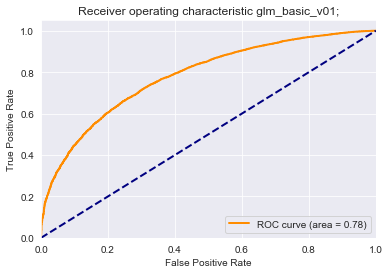

glm prediction progress: |████████████████████████████████████████████████| 100%


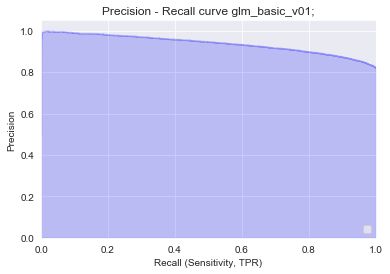

glm prediction progress: |████████████████████████████████████████████████| 100%


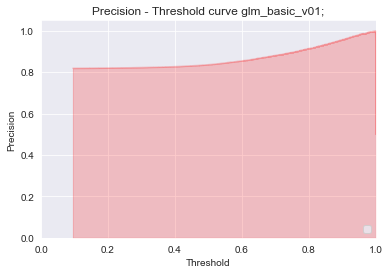

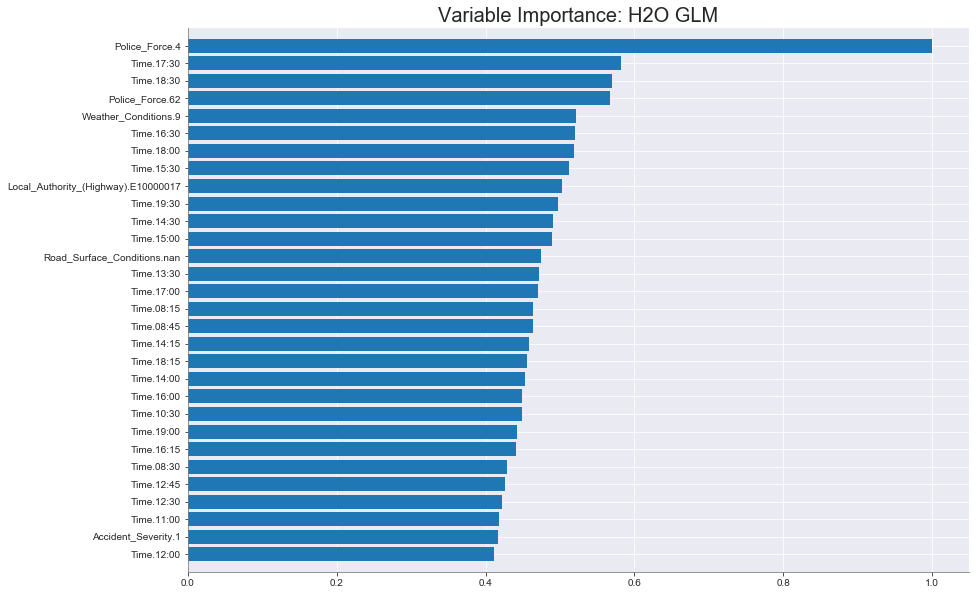

In [78]:
pred_glm=draw_roc(test,model_glm,False)

pr=draw_prec_recall(test,model_glm,False)
pt=draw_prec_thr(test,model_glm,False)


# Drav variable importances from h2o
model_glm.varimp_plot(30)

Time variable treated as a categorical has a peculiar effect on the model, even in the presence of rounded time and the hold out set being selected randomly.

In [79]:
test[['Time','Time_rounded','Time_int']]

Time,Time_rounded,Time_int
14:30,14:30,1.57884e+09
08:50,08:45,1.57882e+09
19:50,19:45,1.57886e+09
16:25,16:30,1.57885e+09
23:05,23:00,1.57887e+09
10:51,10:45,1.57883e+09
12:05,12:00,1.57883e+09
07:05,07:00,1.57881e+09
20:00,20:00,1.57886e+09
08:36,08:30,1.57882e+09


In [88]:
len(test[['Time']].unique())

1397

In [91]:
test[['Time']].unique()

C1
00:01
00:02
00:03
00:04
00:05
00:06
00:07
00:08
00:09
00:10


### Auto Machine Learning

In [80]:
########################################################################################
# Run AutoML for 30 mins
aml = H2OAutoML(max_runtime_secs = 36000)
# aml.train(x=predictors, y=response, training_frame= train, #validation_frame=val,
#           leaderboard_frame = test)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb
#



Parse progress: |█████████████████████████████████████████████████████████| 100%
This H2OFrame is empty.


In [81]:
lb

This H2OFrame is empty.


In [82]:
pred_aml=draw_roc(test,aml.leader,False)
pred_aml=draw_prec_recall(test,aml.leader,False)
pred_aml=draw_prec_thr(test,aml.leader,False)


# Drav variable importances from h2o
aml.leader.varimp_plot(20)

AttributeError: 'NoneType' object has no attribute 'predict'